In [13]:
import duckdb
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from tqdm import tqdm
from copy import deepcopy
from konlpy.tag import Okt
from datetime import datetime
from datetime import timedelta
from curl_cffi import requests
from wordcloud import WordCloud
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import platform
from matplotlib import font_manager, rc

get_ipython().run_line_magic("matplotlib", "inline")
%matplotlib inline

rc("font", family="Arial Unicode MS")

#### DuckDB에 적재된 데이터프레임 추출

In [ ]:
date_filter = '250520'

# DB 파일 연결
con = duckdb.connect(f'/Users/taeheon/stock_price/data/duckdb/{date_filter}_weekend_sentiment_stock.duckdb')

df = con.execute('SELECT * FROM merged_data').fetchdf()

df.tail(13)

date                                                  1  \
1588  2025-05-08       [사설] 삼성전자 8년 만에 M&A, 규제 철폐로 신성장동력 키울 때다 |||    
1589  2025-05-09  압도적인 1위 기록한 삼성전자...보유한 특허권 무려 13만건 ||| 특허권 2위 ...   
1590  2025-05-10                                               None   
1591  2025-05-11  삼성전자, 세계 최초 500Hz OLED 모니터 '오디세이 G6' 출시 ||| 삼성...   
1592  2025-05-12  삼성전자, 美 타임스퀘어 등 글로벌 랜드마크서 '삼성 비전 AI' 옥외광고 ||| ...   
1593  2025-05-13  "미중 관세 휴전에 코스피 2600선 탈환" 삼성전자 5%↑…"韓경제 빨간불" KD...   
1594  2025-05-14  [단독] 삼성전자, 유럽 최대 공조기기 플랙트그룹 20억달러에 인수 ||| 이 기사...   
1595  2025-05-15  삼성전자, '갤럭시 캠퍼스' 가입 대상 확대 ||| [사진=삼성전자] 삼성전자가 공...   
1596  2025-05-16  삼성전자, AI '통버블 세탁기' 선봬··· 사용자 편의성↑ ||| [사진=삼성전자...   
1597  2025-05-17                                               None   
1598  2025-05-18  '반도체 구원투수' 전영현 취임 1년…삼성전자 초격차 회복 주도 ||| 전영현 삼성...   
1599  2025-05-19  용석우 삼성전자 사장, 전자정보통신산업진흥회장 취임 ||| 용석우 제21대 한국전자...   
1600  2025-05-20  “가격 최대 30% 올리겠습니다”...TSMC 결정에 미소짓는 삼성전자, 왜? ||...   

                                                      2  \
1588  AI 절약 모드, 삼성전자의 ‘QLED TV’[2025 지속가능상품 15] ||| ...   
1589  삼성전자의 '300' …AI 선봉대로 전사 생산성 혁신 주도 ||| 삼성전자(005...   
1590                                               None   
1591  삼성전자, 세계 최초 500Hz OLED 게이밍 모니터 출시 ||| QD-OLED·...   
1592  코스피, 미중 관세 우려 덜며 2600선 회복…삼성전자 5% '급등' ||| 12일...   
1593  삼성전자, '5㎜대 초슬림' 갤럭시 S25 엣지 공개 ||| 갤럭시 S25 엣지 [...   
1594  2조원 넘게 쏟아붓는 삼성전자…100년 넘은 독일 기업 인수한다는데 ||| ‘플랙트...   
1595  학생만 받던 삼성전자 '돌변'…갤럭시 캠퍼스, 교사도 품는다 ||| 삼성전자가 스승...   
1596  외국인들, 삼성전자 2900억 쓸어담은 이유가…'깜짝 전망' [종목+] ||| 반도...   
1597                                               None   
1598  취임 1년 맞은 '반도체 구원투수' 전영현…변화 박차 가하는 삼성전자 ||| 전영현...   
1599  삼성전자 OLED TV, 엔비디아 지싱크 호환 인증 ||| 삼성전자(005930)는...   
1600  삼성전자, 전략 리더십 재정비 AI 중심 ‘뉴삼성’ 본격 시동 ||| 삼성전자가 다...   

                                                      3  \
1588  삼성전자 QLED TV, TUV 라인란드 '리얼 퀀텀닷 디스플레이' 인증 획득 ||...   
1589  삼성전자 '비스포크 AI 콤보', 호주서 최고 혁신상 ||| 삼성전자 '비스포크 A...   
1590                                               None   
1591  삼성전자, 제이미 올리버와 런던에 쿠킹 스튜디오 열어 ||| 옥스퍼드 중심가에 체험...   
1592  삼성전자 5% 상승…코스피 46일 만에 2600선 탈환 ||| 미국과 중국의 교역 ...   
1593  스마트폰 '두께 전쟁' 본격화…삼성전자 '초슬림 갤럭시' 공개 [영상] ||| 삼성...   
1594             삼성전자, 유럽 최대 냉난방공조 기업 2조3000억원에 인수 |||    
1595  삼성전자, K팝 라이 그룹 라이즈 '오디세이' 콘텐츠 제작 참여 ||| 삼성전자는 ...   
1596  미국계 로펌 화이트앤케이스, 삼성전자 獨플랙트 인수 자문 ||| [본 기사는 05월...   
1597                                               None   
1598  [단독] '트럼프 리스크' 삼성전자, 美대관 총괄 교체 ||| 삼성전자(005930...   
1599  [주식 초고수는 지금]'6만 전자' 기대감…삼성전자 순매수 1위 ||| 미래에셋증권...   
1600                                               None   

                                                      4  \
1588  삼성전자, 초슬림 '갤럭시 S25 엣지' 13일 공개… 언팩 초대장 발송 ||| 삼...   
1589  삼성전자, 호주서 일냈네…비스포크AI 콤보, 최고혁신상 선정 ||| 삼성전자는 일체...   
1590                                               None   
1591  정부 "대선 앞두고 보안 비상" 삼성전자 등 6천곳에 주의보 ||| 정부가 SK텔레...   
1592  코스피, 46일 만에 2600선 회복...삼성전자 5%대 껑충 ||| 12일 서울 ...   
1593  삼성전자, 우리집 주방에 꼭 맞는 키친핏 냉장고…편리한 푸드 쇼케이스 도어까지 장착...   
1594  삼성전자, 獨 플랙트 2.3조에 인수…글로벌 공조 시장 본격 진출 ||| 삼성전자(...   
1595  삼성전자, 중동 공조시장 공략 강화...“에어솔루션 데이 열어” ||| 중국서 글로...   
1596                                               None   
1597                                               None   
1598  삼성전자, 글로벌 인재 대거 영입...애플·지멘스·GM 등 출신 전진 배치 ||| ...   
1599  용석우 삼성전자 사장, KEA 회장 취임 “AI·공급망 대응 주력” ||| 공급망·...   
1600                                               None   

                                                      5  \
1588  삼성전자 QLED TV, ‘리얼 퀀텀닷 디스플레이’ 인증 획득 ||| 삼성전자는 자...   
1589  삼성전자·SK하이닉스도 아르테미스 2호 큐브위성 협력 ||| 삼성전자(005930)...   
1590                                               None   
1591                                               None   
1592                                               None   
1593  삼성전자, 터치 솔루션 탑재한 삼성 '더 프리미어 5' 프로젝터…일상을 스크린 속으...   
1594  삼성전자, 獨 냉난방공조 플랙트 인수… 2조4000억 규모 ||| 삼성전자 서초사옥...   
1595  삼성전자, '갤럭시 캠퍼스' 가입대상 초중고 교사로 확대 ||| 삼성전자(00593...   
1596 

In [29]:
con.close()

# 1. 데이터 개요 및 결측치 확인
#### 데이터 통계

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1601 non-null   object 
 1   1             1496 non-null   object 
 2   2             1367 non-null   object 
 3   3             1224 non-null   object 
 4   4             1091 non-null   object 
 5   5             963 non-null    object 
 6   6             823 non-null    object 
 7   7             689 non-null    object 
 8   8             585 non-null    object 
 9   9             479 non-null    object 
 10  10            391 non-null    object 
 11  11            314 non-null    object 
 12  12            246 non-null    object 
 13  13            193 non-null    object 
 14  14            157 non-null    object 
 15  15            126 non-null    object 
 16  16            97 non-null     object 
 17  17            80 non-null     object 
 18  18            62 non-null   

In [31]:
df.describe()

news_count  avg_negative  avg_neutral  avg_positive          open  \
count  1601.000000   1601.000000  1601.000000   1601.000000   1601.000000   
mean      6.680824      0.173727     0.407003      0.419267  69290.505934   
std       5.375285      0.222105     0.301521      0.293176   9526.210412   
min       0.000000      0.000000     0.000000      0.000000  50200.000000   
25%       3.000000      0.001500     0.182000      0.188600  60800.000000   
50%       6.000000      0.088100     0.350200      0.435500  70200.000000   
75%       9.000000      0.268100     0.573600      0.629800  77400.000000   
max      39.000000      0.999800     1.000000      0.999900  90300.000000   

               high           low         close        volume        label  
count   1601.000000   1601.000000   1601.000000  1.601000e+03  1601.000000  
mean   69884.509681  68660.961899  69214.678326  1.685122e+07     0.297314  
std     9541.830139   9419.976450   9481.341053  8.535307e+06     0.457219  
min    51400.000000  49900.000000  49900.000000  0.000000e+00     0.000000  
25%    61300.000000  60300.000000  60600.000000  1.182253e+07     0.000000  
50%    70700.000000  69700.000000  70200.000000  1.504031e+07     0.000000  
75%    77800.000000  76500.000000  77200.000000  2.018807e+07     1.000000  
max    96800.000000  89500.000000  91000.000000  9.030618e+07     1.000000

#### 기사 원문 컬럼 개수 파악

In [32]:
# 기사 원문 컬럼 개수
numeric_str_columns = [col for col in df.columns if col.isdigit()]

# 개수 출력
print(f"숫자로 된 문자열 컬럼 개수: {len(numeric_str_columns)}")

숫자로 된 문자열 컬럼 개수: 39


- NaN이 아닌 값의 개수 집계

In [33]:
# NaN/Non-NaN 개수 계산
non_missing_counts = df[numeric_str_columns].notna().sum()
missing_counts = df[numeric_str_columns].isna().sum()

# 원하는 구조로 데이터프레임 생성
missing_summary = pd.DataFrame(
    [non_missing_counts.values, missing_counts.values],
    index=['Not NaN 개수', 'NaN 개수'],
    columns=numeric_str_columns
)

# 결과 확인
missing_summary

1     2     3     4    5    6    7     8     9    10  ...  \
Not NaN 개수  1496  1367  1224  1091  963  823  689   585   479   391  ...   
NaN 개수       105   234   377   510  638  778  912  1016  1122  1210  ...   

              30    31    32    33    34    35    36    37    38    39  
Not NaN 개수     9     8     8     4     4     2     1     1     1     1  
NaN 개수      1592  1593  1593  1597  1597  1599  1600  1600  1600  1600  

[2 rows x 39 columns]

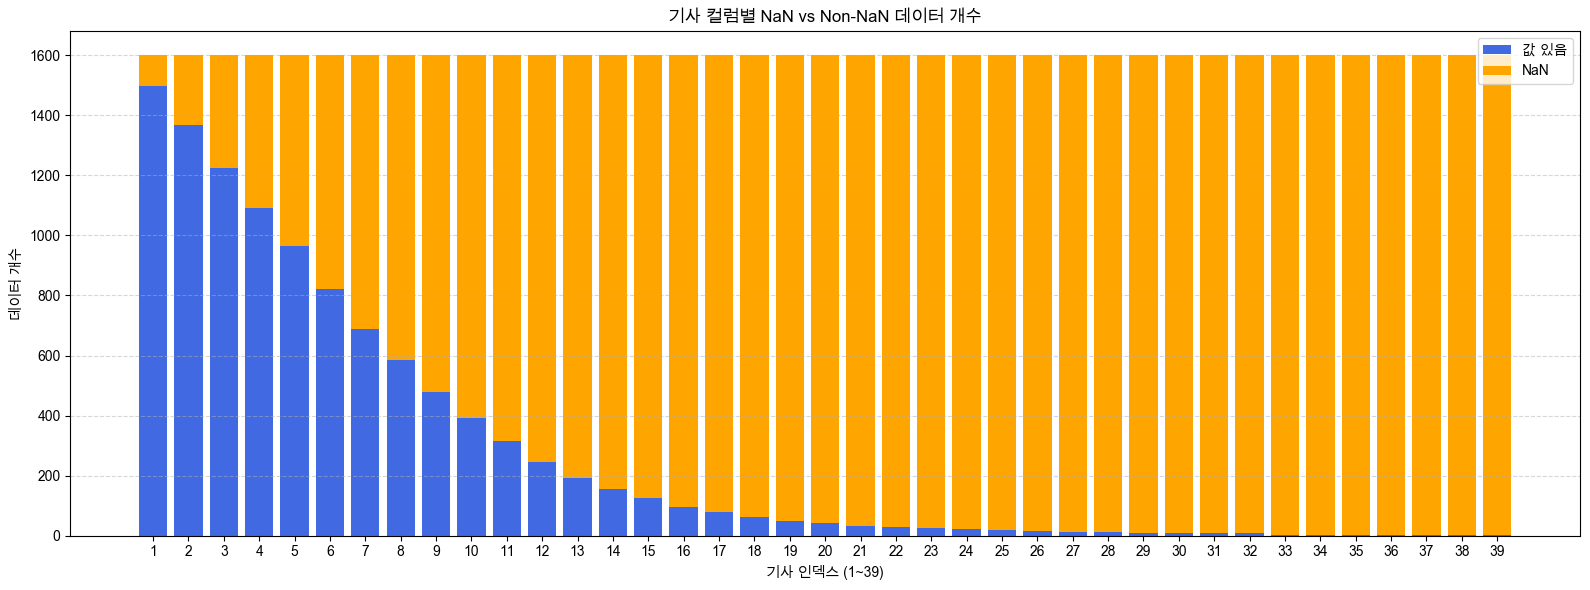

In [8]:
# NaN 아닌 값 개수
non_missing_counts = df[numeric_str_columns].notna().sum()
# NaN 값 개수
missing_counts = df[numeric_str_columns].isna().sum()

# 누적 막대그래프
plt.figure(figsize=(16, 6))
plt.bar(numeric_str_columns, non_missing_counts, label='값 있음', color='royalblue')
plt.bar(numeric_str_columns, missing_counts, bottom=non_missing_counts, label='NaN', color='orange')

plt.title('기사 컬럼별 NaN vs Non-NaN 데이터 개수')
plt.xlabel('기사 인덱스 (1~39)')
plt.ylabel('데이터 개수')
plt.xticks(rotation=0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### 전체 수집 날짜 수, 기사 수 통계

In [34]:
# 전체 수집 날짜 수
total_dates = df['date'].nunique()

# 전체 수집 기사 수 (각 날짜의 news_count 합산)
total_news_cnt = df['news_count'].sum()

print(f"전체 수집 날짜 수 : {total_dates}")
print(f"전체 수집 기사 수 : {total_news_cnt}")

전체 수집 날짜 수 : 1601
전체 수집 기사 수 : 10696


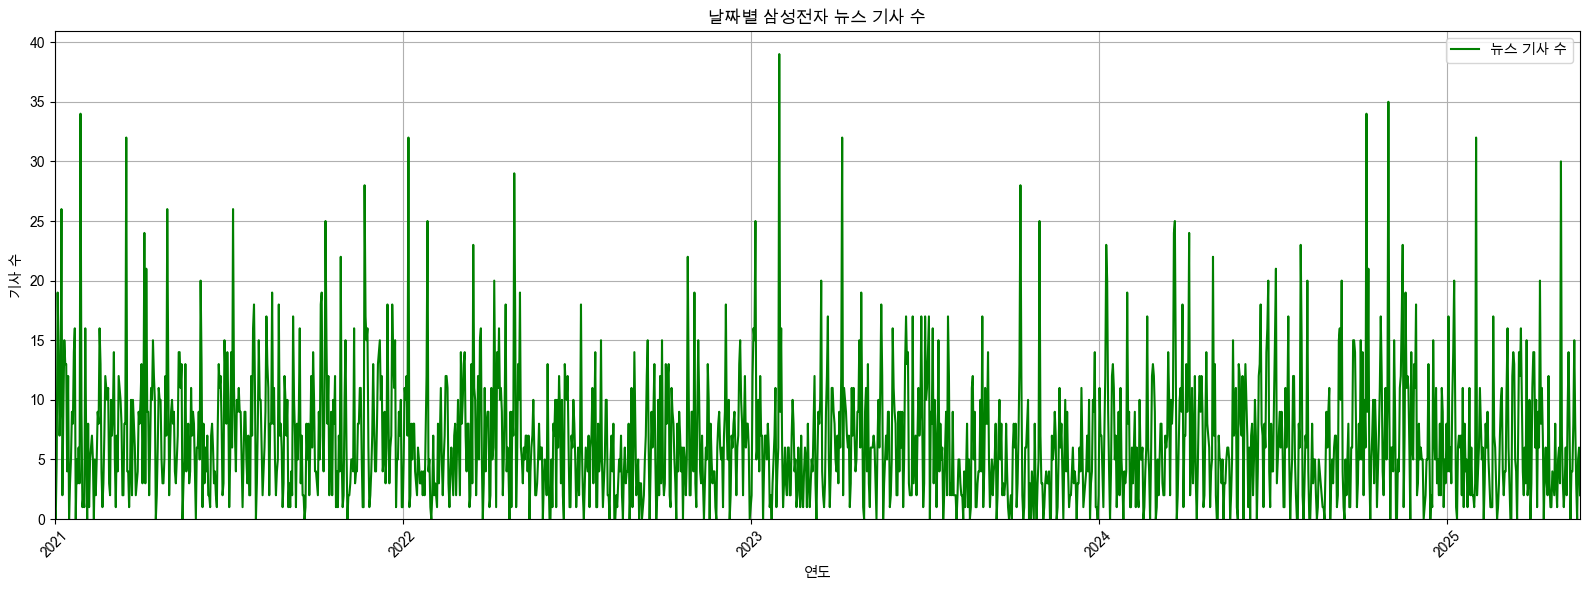

In [10]:
import matplotlib.dates as mdates

# 날짜 파싱 및 유효한 날짜만 필터링
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # 잘못된 날짜는 NaT로 처리
df = df.dropna(subset=['date'])  # NaT 제거

# 시각화
plt.figure(figsize=(16, 6))
plt.plot(df['date'], df['news_count'], label='뉴스 기사 수', color='green')

plt.title("날짜별 삼성전자 뉴스 기사 수")
plt.xlabel("연도")
plt.ylabel("기사 수")

# x축: 연도만 표시
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # 매년
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 연도만 텍스트로

# x축 라벨 회전
plt.xticks(rotation=45)

# y축 0부터 시작
plt.xlim(left=df['date'].min(), right=df['date'].max())
plt.ylim(bottom=0)

# 그리드 및 범례
plt.grid(True)
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()

#### 기사 수가 가장 많은 날과 가장 적은 날 비교
- 각 날짜의 기사 개수와 감성 확률

In [11]:
# 기사 수가 가장 많은 날
max_news_count = df['news_count'].max()
most_articles_df = df[df['news_count'] == max_news_count]

# 기사 수가 0인 날 (가장 적은 날)
least_articles_df = df[df['news_count'] == 0]

In [12]:
print(f"기사 수 가장 많은 날 : 기사 {most_articles_df['news_count'].item()}개")
most_articles_df

기사 수 가장 많은 날 : 기사 39개


date                                                  1  \
760 2023-01-31  삼성전자, 오늘 지난해 4분기 확정 실적 공개한다 ||| [사진=연합뉴스] 삼성전자...   

                                                     2  \
760  삼성전자, 확정실적 발표…반도체 감산 선언하나 ||| 지난해 4분기 잠정실적 발표에...   

                                                     3  \
760  FOMC 앞둔 美증시 하락…삼성전자 '반도체 감산' 여부 주목 [모닝브리핑] |||...   

                                                   4  \
760  반도체 한파…삼성전자 감산 여부 주목 [증시 개장 전 꼭 알아야 할 5가지] |||    

                                                     5  \
760  삼성전자, 오스카상 영화감독과 협업…갤럭시 촬영 단편영화 공개 ||| 삼성전자가 오...   

                                                     6  \
760  삼성전자, 4분기 반도체 영업익 0.27조, 전년比 96.94% 폭락…가전은 적자 ...   

                                                     7  \
760  삼성전자, 작년 영업익 43조3766억…전년비 16% 감소[주목 e공시] ||| 삼...   

                                                     8  \
760  [1보] 삼성전자, 지난해 연 매출 300조 돌파…영업익 16% 감소 ||| 삼성전...   

                                                     9  ... news_count  \
760  삼성전자, 보통주 361원·우선주 362원 현금배당 결정[주목 e공시] ||| 삼성...  ...         39   

    avg_negative avg_neutral avg_positive     open     high      low    close  \
760       0.5492      0.1953       0.2555  63500.0  63700.0  61000.0  61400.0   

       volume label  
760  163847.0     0  

[1 rows x 50 columns]

In [13]:
print(f"기사 수 적은 많은 날 : {len(least_articles_df)}일")
least_articles_df

기사 수 적은 많은 날 : 105일


date     1     2     3     4     5     6     7     8     9  ...  \
1    2021-01-02  None  None  None  None  None  None  None  None  None  ...   
15   2021-01-16  None  None  None  None  None  None  None  None  None  ...   
22   2021-01-23  None  None  None  None  None  None  None  None  None  ...   
34   2021-02-04  None  None  None  None  None  None  None  None  None  ...   
41   2021-02-11  None  None  None  None  None  None  None  None  None  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
1534 2025-03-15  None  None  None  None  None  None  None  None  None  ...   
1548 2025-03-29  None  None  None  None  None  None  None  None  None  ...   
1562 2025-04-12  None  None  None  None  None  None  None  None  None  ...   
1590 2025-05-10  None  None  None  None  None  None  None  None  None  ...   
1597 2025-05-17  None  None  None  None  None  None  None  None  None  ...   

     news_count avg_negative avg_neutral avg_positive     open     high  \
1             0          0.0         1.0          0.0  77400.0  81300.0   
15            0          0.0         1.0          0.0  89800.0  91800.0   
22            0          0.0         1.0          0.0  89000.0  89700.0   
34            0          0.0         1.0          0.0  83500.0  83800.0   
41            0          0.0         1.0          0.0  82600.0  82600.0   
...         ...          ...         ...          ...      ...      ...   
1534          0          0.0         1.0          0.0  54500.0  55100.0   
1548          0          0.0         1.0          0.0  60700.0  61100.0   
1562          0          0.0         1.0          0.0  55600.0  55700.0   
1590          0          0.0         1.0          0.0  54700.0  55000.0   
1597          0          0.0         1.0          0.0  57400.0  57500.0   

          low    close      volume label  
1     77300.0  81000.0  29417421.0     0  
15    88000.0  88000.0  33431809.0     0  
22    86800.0  86800.0  30861661.0     0  
34    82100.0  82500.0  24171688.0     1  
41    81600.0  81600.0  23025766.0     0  
...       ...      ...         ...   ...  
1534  54400.0  54700.0  10845154.0     0  
1548  60000.0  60200.0  16282514.0     0  
1562  54800.0  55200.0  13930480.0     0  
1590  54400.0  54800.0   7814322.0     0  
1597  56700.0  56800.0  10385352.0     0  

[105 rows x 50 columns]

##### 기사 수 가장 많은 날의 워드클라우드

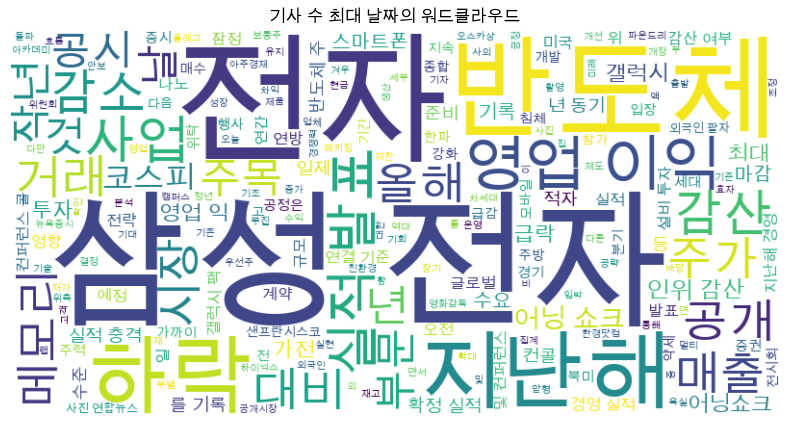

In [14]:
# 형태소 분석기
okt = Okt()

# 뉴스 원문만 추출하고 NaN제거
news_texts = most_articles_df.iloc[:, 1:40].apply(lambda row : ' '.join(row.dropna().astype(str)), axis=1)
all_text = ' '.join(news_texts)

# 형태소 분석 후 명사만 추출 (조사 등 제거)
nouns = okt.nouns(all_text)
filtered_text = ' '.join(nouns)

# 워드클라우드 생성
font_path = fm.findfont("Arial Unicode MS")
wordcloud = WordCloud(font_path=font_path, background_color='white', width=800, height=400).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("기사 수 최대 날짜의 워드클라우드")
plt.show()

#### 기사가 가장 많은 날의 뉴스 기사 TF-IDF 분석

In [15]:
# 뉴스 원문을 명사 기반으로 문서화
documents = []

for _, row in most_articles_df.iloc[:, 1:40].iterrows() :
    text = ' '.join(row.dropna().astype(str))   # NaN 제거
    nouns = okt.nouns(text)     # 명사만 추출
    documents.append(' '.join(nouns))

vectorizer = TfidfVectorizer(max_features=50)
tfidf_matrix = vectorizer.fit_transform(documents)

# 키워드 및 점수 추출
keywords = vectorizer.get_feature_names_out()
scores = tfidf_matrix.sum(axis=0).A1

sorted_items = sorted(zip(keywords, scores), key=lambda x : x[1], reverse=True)
for word, score in sorted_items[:20] :
    print(f"{word} : {score:.2f}")

전자 : 0.66
삼성 : 0.35
반도체 : 0.29
실적 : 0.24
영업 : 0.20
감산 : 0.18
지난해 : 0.17
발표 : 0.13
하락 : 0.13
이익 : 0.13
사업 : 0.09
갤럭시 : 0.09
기록 : 0.09
투자 : 0.09
감소 : 0.08
거래 : 0.07
공개 : 0.07
대비 : 0.07
매출 : 0.07
메모리 : 0.07


#### 부정, 중립, 긍정의 감성 분포

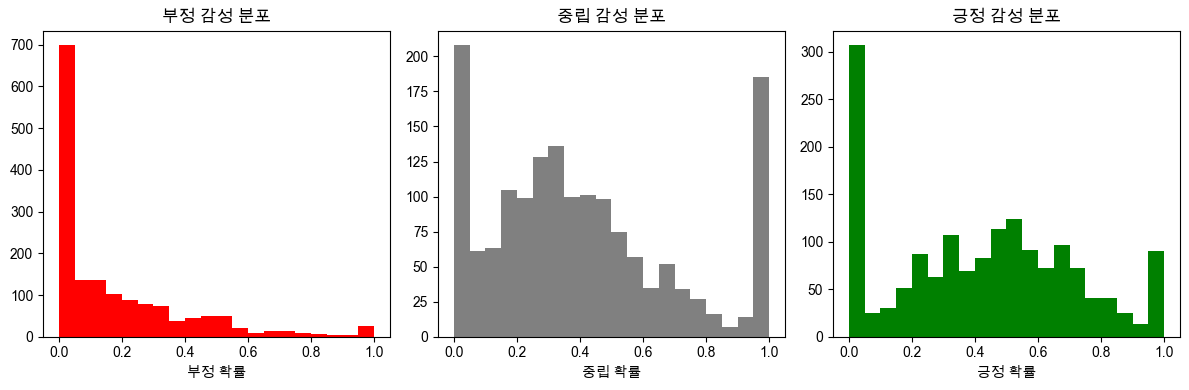

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df['avg_negative'].dropna(), bins=20, color='red')
plt.title("부정 감성 분포")
plt.xlabel("부정 확률")

plt.subplot(1, 3, 2)
plt.hist(df['avg_neutral'].dropna(), bins=20, color='gray')
plt.title("중립 감성 분포")
plt.xlabel("중립 확률")

plt.subplot(1, 3, 3)
plt.hist(df['avg_positive'].dropna(), bins=20, color='green')
plt.title("긍정 감성 분포")
plt.xlabel("긍정 확률")

plt.tight_layout()
plt.show()

#### 평균, 중앙값, 최대/최소, IQR
- news_count, avg_negative, avg_neutral, avg_positive, close, volume

In [17]:
features = ['news_count', 'avg_negative', 'avg_neutral', 'avg_positive', 'close', 'volume']

for feature in features :
    print(f"==============={feature} 기초 통계===============")

    mean = np.mean(df[f'{feature}'])
    median = np.median(df[f'{feature}'])
    maximum = np.max(df[f'{feature}'])
    minimum = np.min(df[f'{feature}'])
    des = df[f'{feature}'].describe()
    q1 = des['25%']
    q2 = des['50%']
    q3 = des['75%']

    if feature == 'news_count' :
        total_num = df['news_count'].count()
        print(f"news_count 총 개수 : {total_num}")

    if feature == 'close' :
        print(f"{feature} 평균값 : ₩{round(mean,2)}")
        print(f"{feature} 중앙값 : ₩{int(median)}")
        print(f"{feature} 최댓값 : ₩{int(maximum)}")
        print(f"{feature} 최솟값 : ₩{int(minimum)}")
        print(f"{feature} IQR(25%) : ₩{int(q1)}")
        print(f"{feature} IQR(50%) : ₩{int(q2)}")
        print(f"{feature} IQR(75%) : ₩{int(q3)}")
    else :
        print(f"{feature} 평균값 : {round(mean,2)}")
        print(f"{feature} 중앙값 : {median}")
        print(f"{feature} 최댓값 : {maximum}")
        print(f"{feature} 최솟값 : {minimum}")
        print(f"{feature} IQR(25%) : {q1}")
        print(f"{feature} IQR(50%) : {q2}")
        print(f"{feature} IQR(75%) : {q3}")

===============news_count 기초 통계===============
news_count 총 개수 : 1601
news_count 평균값 : 6.68
news_count 중앙값 : 6.0
news_count 최댓값 : 39
news_count 최솟값 : 0
news_count IQR(25%) : 3.0
news_count IQR(50%) : 6.0
news_count IQR(75%) : 9.0
===============avg_negative 기초 통계===============
avg_negative 평균값 : 0.17
avg_negative 중앙값 : 0.0881
avg_negative 최댓값 : 0.9998
avg_negative 최솟값 : 0.0
avg_negative IQR(25%) : 0.0015
avg_negative IQR(50%) : 0.0881
avg_negative IQR(75%) : 0.2681
===============avg_neutral 기초 통계===============
avg_neutral 평균값 : 0.41
avg_neutral 중앙값 : 0.3502
avg_neutral 최댓값 : 1.0
avg_neutral 최솟값 : 0.0
avg_neutral IQR(25%) : 0.182
avg_neutral IQR(50%) : 0.3502
avg_neutral IQR(75%) : 0.5736
===============avg_positive 기초 통계===============
avg_positive 평균값 : 0.42
avg_positive 중앙값 : 0.4355
avg_positive 최댓값 : 0.9999
avg_positive 최솟값 : 0.0
avg_positive IQR(25%) : 0.1886
avg_positive IQR(50%) : 0.4355
avg_positive IQR(75%) : 0.6298
===============close 기초 통계===============
close 평균값 : ₩6921

#### label별 0, 1 데이터 개수 및 비율

In [18]:
df['label'].value_counts()

label
0    1125
1     476
Name: count, dtype: int64

label 0 개수 : 1125
label 1 개수 : 476


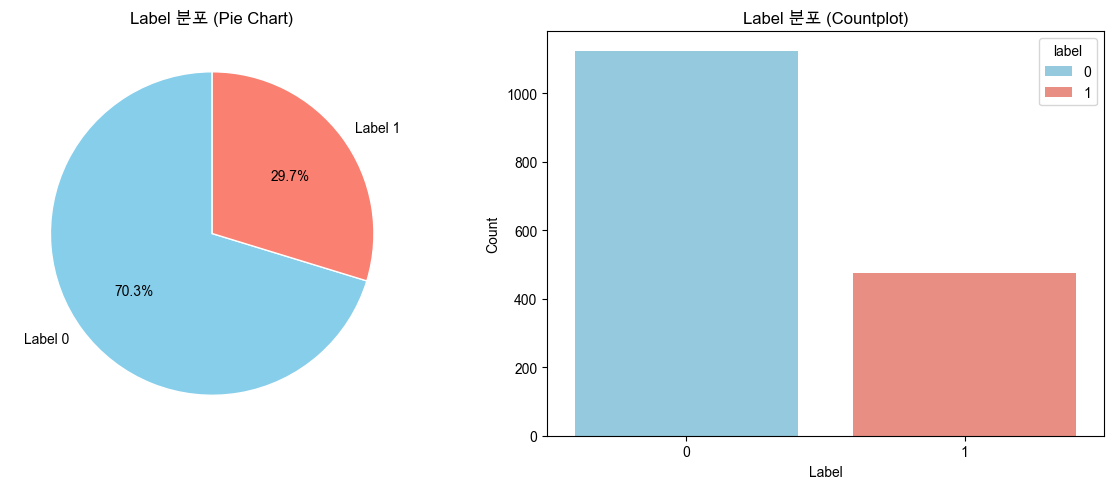

In [19]:
# 라벨별 개수 계산
label_counts = df['label'].value_counts().sort_index()
labels = ['Label 0', 'Label 1']
total = label_counts.sum()
label_ratios = {0: label_counts[0] / total * 100, 1: label_counts[1] / total * 100}

print(f"label 0 개수 : {label_counts[0]}")
print(f"label 1 개수 : {label_counts[1]}")

# 서브플롯 생성 (1행 2열)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 파이차트
ax1.pie(
    label_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'salmon'],
    wedgeprops={'edgecolor': 'white'}
)
ax1.set_title('Label 분포 (Pie Chart)')

# Countplot
sns.countplot(x='label', data=df, ax=ax2, hue=df['label'], palette=['skyblue', 'salmon'])

ax2.set_title('Label 분포 (Countplot)')
ax2.set_xlabel('Label')
ax2.set_ylabel('Count')

# 전체 레이아웃 정리
plt.tight_layout()
plt.show()

##### ⇒ ***label 0 클래스의 비중이 label 1 클래스 비중보다 약 2.5배 더 높다.***

#### 입력 데이터의 유효성 검증
- 감성 스코어 3개 합이 1이 되는지 확인

In [20]:
total_prob = 0

for i in range(len(df)) :
    total_prob += np.sum(df['avg_positive'][i]) + np.sum(df['avg_neutral'][i]) + np.sum(df['avg_negative'][i])

print(len(df), round(total_prob, 2))

1601 1601.0


- 감성 스코어는 평균값이라 소수점에서 차이가 약간 발생
##### ⇒ ***전체 데이터 개수와 감성 스코어 3개의 총 합이 일치***

# 2. 감성 분포 분석
#### **label==1인 경우에 avg_positive가 높을까?**
- 상승일과 하락일의 avg_negative, avg_neutral, avg_positive의 평균 비교

In [21]:
tmp_df2 = deepcopy(df)

tmp_df2 = tmp_df2.groupby('label')[['avg_negative', 'avg_neutral', 'avg_positive']]

# 확률값 총 합
tmp_df2.sum()

avg_negative  avg_neutral  avg_positive
label                                         
0          203.7188     470.6319      450.6461
1           74.4188     180.9807      220.6009

In [22]:
# 확률값 평균
tmp_df2.mean()

avg_negative  avg_neutral  avg_positive
label                                         
0          0.181083     0.418339      0.400574
1          0.156342     0.380212      0.463447

- label 0 (하락 or 유지) : avg_neutral의 비중이 높고, avg_negative보다 avg_positive가 더 높다.
- label 1 (상승) : avg_positive의 비중이 가장 높지만, avg_neutral의 비중과 큰 차이가 없다.
##### ⇒ ***avg_neutral의 비중이 label 0, 1 두 클래스에서 모두 높은 비중을 차지하고 있다.***

## 부정/중립/긍정 감성 분포의 시간 흐름에 따른 변화 추이
- 15일 이동평균을 적용해 그래프 간소화
- positive-negative 관계 파악

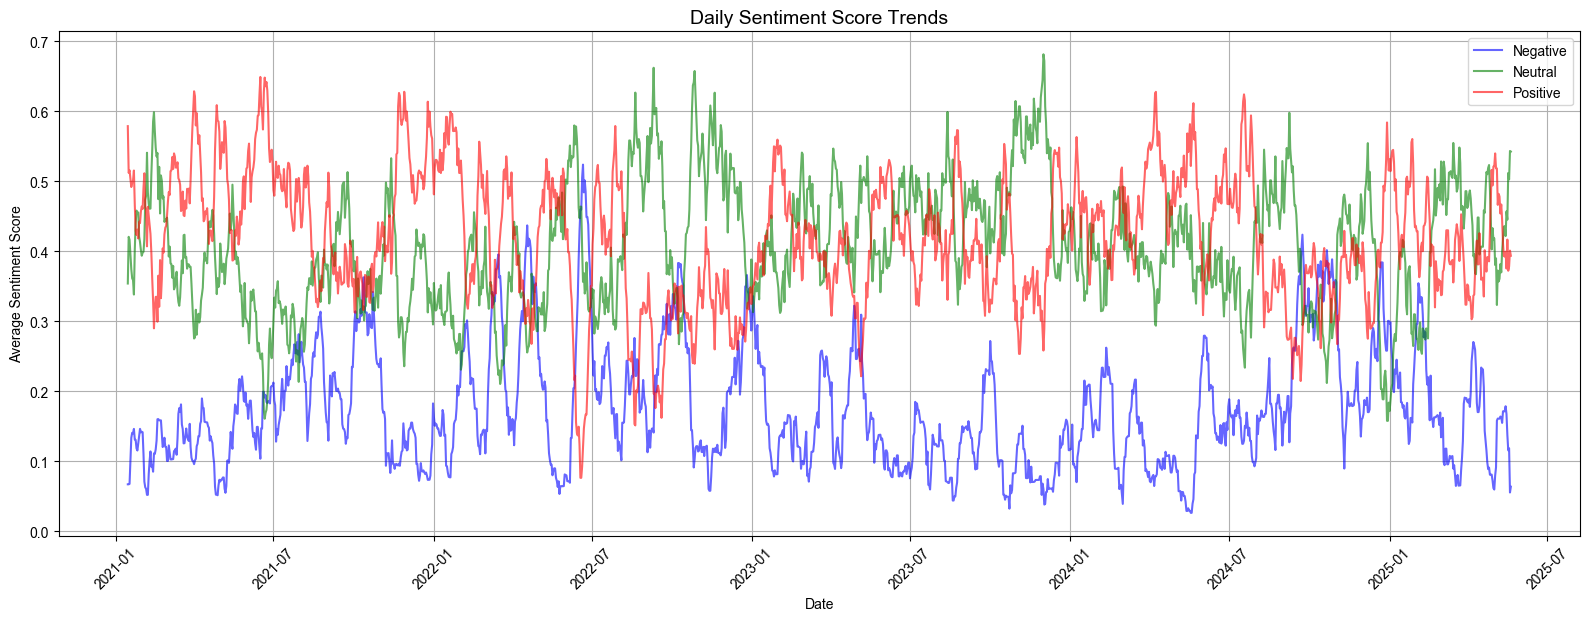

In [72]:
tmp_df1 = deepcopy(df)

# 날짜 컬럼을 datetime 형식으로 변환
tmp_df1['date'] = pd.to_datetime(tmp_df1['date'])

# 날짜 기준 정렬
tmp_df1 = tmp_df1.sort_values('date')

tmp_df1['neg_ma15'] = tmp_df1['avg_negative'].rolling(window=15).mean()
tmp_df1['neu_ma15'] = tmp_df1['avg_neutral'].rolling(window=15).mean()
tmp_df1['pos_ma15'] = tmp_df1['avg_positive'].rolling(window=15).mean()

# 시계열 선 그래프
plt.figure(figsize=(16,6))
plt.plot(tmp_df1['date'], tmp_df1['neg_ma15'], label='Negative', color='blue', alpha=0.6)
plt.plot(tmp_df1['date'], tmp_df1['neu_ma15'], label='Neutral', color='green', alpha=0.6)
plt.plot(tmp_df1['date'], tmp_df1['pos_ma15'], label='Positive', color='red', alpha=0.6)

# 시각화
plt.title("Daily Sentiment Score Trends", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

- 3개의 감성 점수와 close 변동 비교

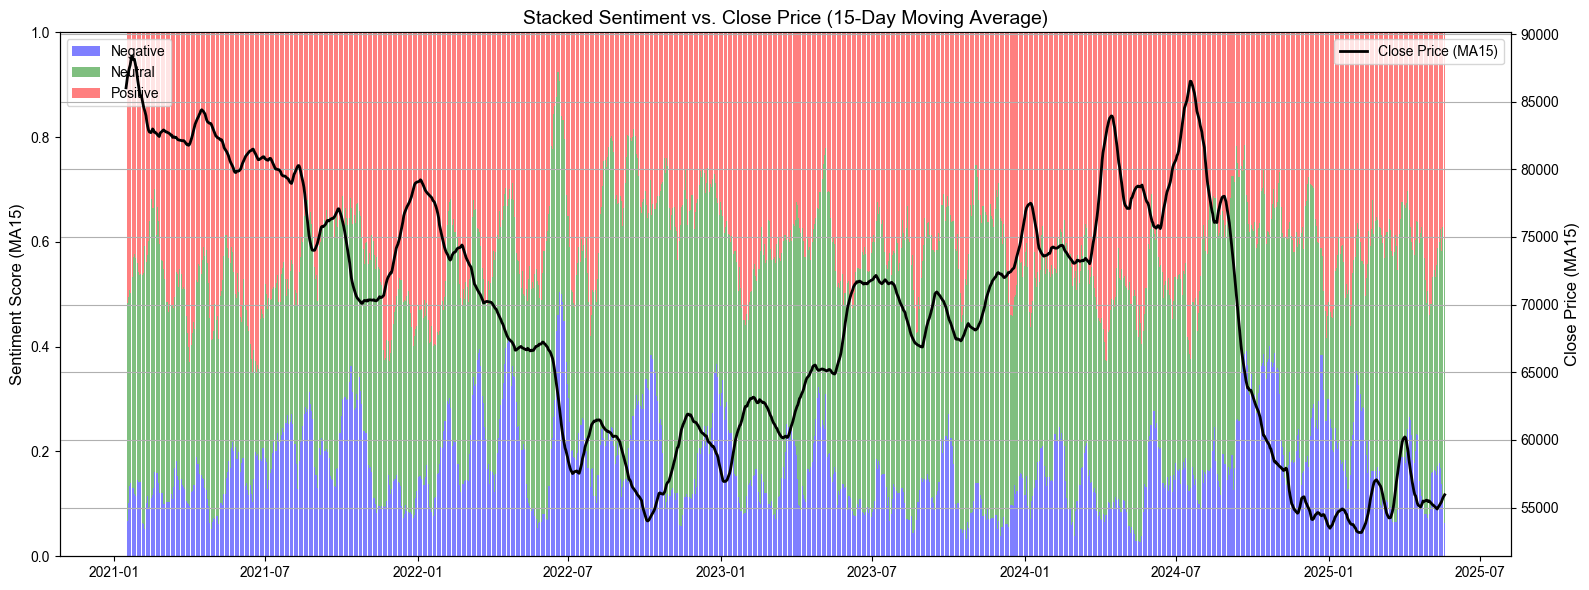

In [73]:
tmp_df1['close_ma15'] = tmp_df1['close'].rolling(window=15).mean()

# NaN이 없는 구간만 선택
plot_df = tmp_df1.dropna(subset=['neg_ma15', 'neu_ma15', 'pos_ma15', 'close_ma15'])

# 시각화 데이터 추출
x = plot_df['date']
neg = plot_df['neg_ma15']
neu = plot_df['neu_ma15']
pos = plot_df['pos_ma15']
close = plot_df['close_ma15']

# 시각화 시작
fig, ax1 = plt.subplots(figsize=(16, 6))

# Stacked Bar (감성 비중)
ax1.bar(x, neg, label='Negative', color='blue', alpha=0.5)
ax1.bar(x, neu, bottom=neg, label='Neutral', color='green', alpha=0.5)
ax1.bar(x, pos, bottom=neg + neu, label='Positive', color='red', alpha=0.5)

# 첫 번째 y축 라벨 및 범위
ax1.set_ylabel('Sentiment Score (MA15)', fontsize=12)
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')

# 두 번째 y축 (주가)
ax2 = ax1.twinx()
ax2.plot(x, close, label='Close Price (MA15)', color='black', linewidth=2)
ax2.set_ylabel('Close Price (MA15)', fontsize=12)
ax2.legend(loc='upper right')

# 전체 제목, 축 스타일
plt.title('Stacked Sentiment vs. Close Price (15-Day Moving Average)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()

plt.show()

#### `avg_positive` - `close` 시계열 라인플롯
- 동조성 여부 확인
- avg_positive와 close 스케일링 : MinMaxScaler

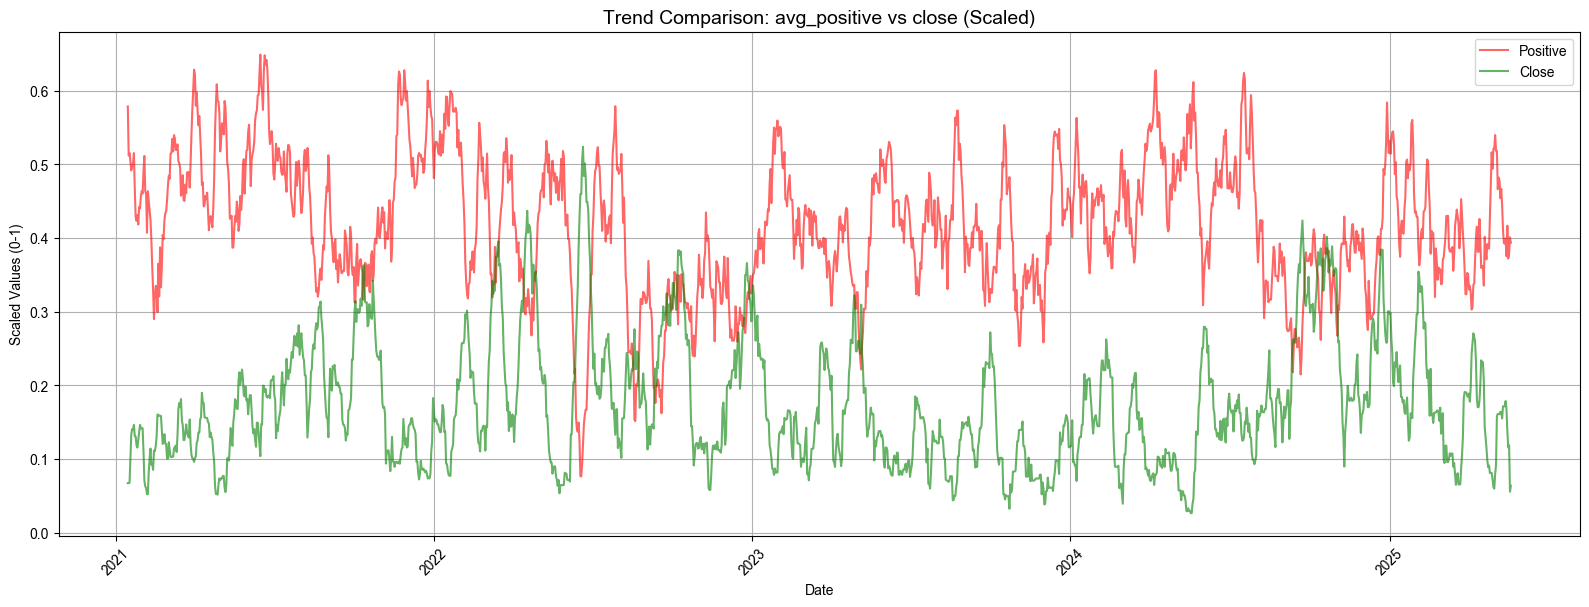

In [25]:
tmp_df3 = deepcopy(df)

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(tmp_df3[['avg_positive', 'avg_negative']])

tmp_df3['avg_positive_scaled'] = scaled_values[:, 0]
tmp_df3['close_scaled'] = scaled_values[:, 1]

tmp_df3['pos_ma15'] = tmp_df3['avg_positive_scaled'].rolling(window=15).mean()
tmp_df3['cls_ma15'] = tmp_df3['close_scaled'].rolling(window=15).mean()

# 시계열 선 그래프
plt.figure(figsize=(16,6))
plt.plot(tmp_df3['date'], tmp_df3['pos_ma15'], label='Positive', color='red', alpha=0.6)
plt.plot(tmp_df3['date'], tmp_df3['cls_ma15'], label='Close', color='green', alpha=0.6)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # 매년
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 연도만 텍스트로

# 시각화
plt.title('Trend Comparison: avg_positive vs close (Scaled)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Scaled Values (0-1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

#### label별 감성 점수
- label이 1일 때 `avg_positive` - `avg_negative`의 분포 vs 0일 때와 비교

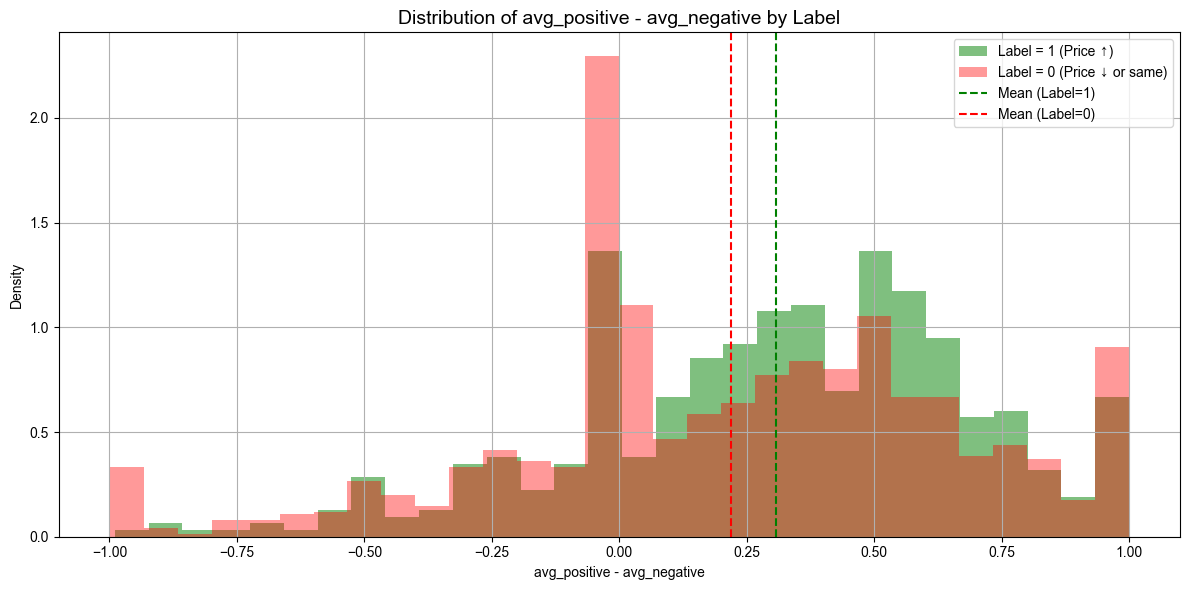

In [26]:
tmp_df5 = deepcopy(df)

# sentiment 차이 계산
tmp_df5['sentiment_diff'] = tmp_df5['avg_positive'] - tmp_df5['avg_negative']

# label 기준으로 분할
diff_up = tmp_df5[tmp_df5['label'] == 1]['sentiment_diff']
diff_down = tmp_df5[tmp_df5['label'] == 0]['sentiment_diff']

# 시각화 (히스토그램 + 밀도 추정)
plt.figure(figsize=(12, 6))
plt.hist(diff_up, bins=30, alpha=0.5, label='Label = 1 (Price ↑)', color='green', density=True)
plt.hist(diff_down, bins=30, alpha=0.4, label='Label = 0 (Price ↓ or same)', color='red', density=True)

plt.axvline(diff_up.mean(), color='green', linestyle='--', label='Mean (Label=1)')
plt.axvline(diff_down.mean(), color='red', linestyle='--', label='Mean (Label=0)')

plt.title('Distribution of avg_positive - avg_negative by Label', fontsize=14)
plt.xlabel('avg_positive - avg_negative')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- x축 : avg_positive - avg_negative (긍정 감성 점수에서 부정 감성 점수를 뺀 값)
- y축 : 확률 밀도 (densitive=True이므로 정규화된 값)
- 두 집단
    - 초록 : label = 1 (다음날 주가 상승)
    - 빨강 : label = 0 (다음날 주가 하락 or 유지)
- 점선
    - 초록 : 상승일의 평균값
    - 빨강 : 하락/유지일의 평균값

##### 1. label=1의 평균이 label=0의 평균보다 오른쪽에 위치
- 상승한 날의 avg_positive - avg_negative 평균이 더 크다
- 즉, **긍정 감성이 부정 감성보다 더 강했던 날일수록 주가가 오를 확률이 높았다**는 경향
##### 2. 분포 형태 해석
- label=1 (초록)
    - 전반적으로 0.25 ~ 0.6 부근에 밀도가 높음
    - 일부는 0보다 작지만, 대부분이 긍정이 우세한 구간에 있음
- label=0 (빨강)
    - 0 이하의 값이 상대적(초록 대비)으로 더 많이 분포
    - 전체적으로 좌우 분산이 크고, 중앙값이 더 왼쪽에 치우침
- 즉, **상승하지 않은 날은 긍정이 우세하지 않거나 오히려 부정 감성이 더 많은 날일 확률이 높았음**

# 3. 상관 분석
- news_count, avg_negative, avg_neutral, avg_positive, open, high, low, close, volume, label
- 분석 포인트
    - label과 연관이 높은 감성 지표 확인
    - volume ↔ news_count의 관계
    - avg_negative ↔ avg_positive 관계

In [61]:
tmp_df6 = deepcopy(df)

tmp_df6 = tmp_df6[['news_count', 'avg_negative', 'avg_neutral', 'avg_positive', 'open', 'high', 'low', 'close', 'volume']]

corr_df = tmp_df6.corr()

corr_df

news_count  avg_negative  avg_neutral  avg_positive      open  \
news_count      1.000000      0.074455    -0.295372      0.247375  0.060538   
avg_negative    0.074455      1.000000    -0.405356     -0.340690 -0.128998   
avg_neutral    -0.295372     -0.405356     1.000000     -0.721369 -0.043562   
avg_positive    0.247375     -0.340690    -0.721369      1.000000  0.142533   
open            0.060538     -0.128998    -0.043562      0.142533  1.000000   
high            0.072068     -0.131762    -0.045211      0.146324  0.997564   
low             0.059950     -0.133092    -0.043161      0.145223  0.998492   
close           0.068416     -0.136154    -0.044927      0.149359  0.995655   
volume          0.212838      0.106136    -0.065682     -0.012860  0.123433   

                  high       low     close    volume  
news_count    0.072068  0.059950  0.068416  0.212838  
avg_negative -0.131762 -0.133092 -0.136154  0.106136  
avg_neutral  -0.045211 -0.043161 -0.044927 -0.065682  
avg_positive  0.146324  0.145223  0.149359 -0.012860  
open          0.997564  0.998492  0.995655  0.123433  
high          1.000000  0.997468  0.998179  0.154656  
low           0.997468  1.000000  0.997888  0.109395  
close         0.998179  0.997888  1.000000  0.133343  
volume        0.154656  0.109395  0.133343  1.000000

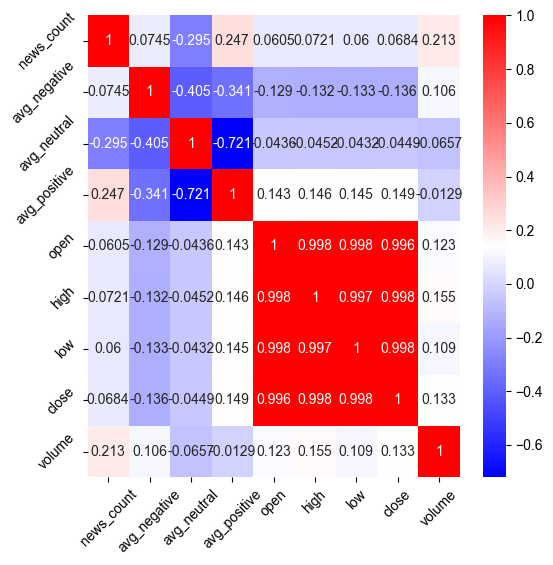

In [64]:
plt.figure(figsize=(6,6))
sns.heatmap(corr_df, annot=True, fmt='.3g', cmap='bwr')

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

1. label과 가장 연관이 높은 feature : news_count
    - 가장 높은 상관계수값마저도 0.14로 크게 영향이 없다
    - 감성 점수는 avg_positive, avg_neutral, avg_negative순으로 연관성이 높았으며, 모두 0.1 아래 수준으로 매우 낮다.
    - **단순 상관으로는 예측력이 낮다.**


2. volume과 news_count는 0.21의 상관계수


3. avg_negative는 avg_positive와 음의 상관계수를 가지고 있으며, close와도 음의 상관계수를 갖는다.
    - **부정 뉴스가 많아질수록 중립/긍정 뉴스가 줄고, 주가는 약간 하락 경향을 보인다.**


4. avg_neutral은 avg_positive와 -0.721이라는 매우 강한 음의 상관관계를 보인다.
    - **중립 뉴스가 많아질수록 긍정 뉴스는 적다. 주가와의 상관은 거의 없다.**


5. avg_positive는 가격지표들과 소폭 양의 상관관계를 보인다.
    - **긍정 감성이 있는 경우 평균적으로 주가는 상승하는 경향이 있다.**


6. news_count는 가격지표와의 상관은 약하지만, avg_neutral, avg_positive와의 상관관계가 높다.
    - **뉴스 개수가 많을수록 중립, 긍정에 대한 감성 표현이 더 뚜렷한 경우가 있다.**

    
7. 주가 데이터(open, high, low, close)는 서로 굉장히 높은 상관계수를 갖는다. 

# 4. 뉴스 원문 활용 텍스트 기반 인사이트 검색

#### 워드 클라우드

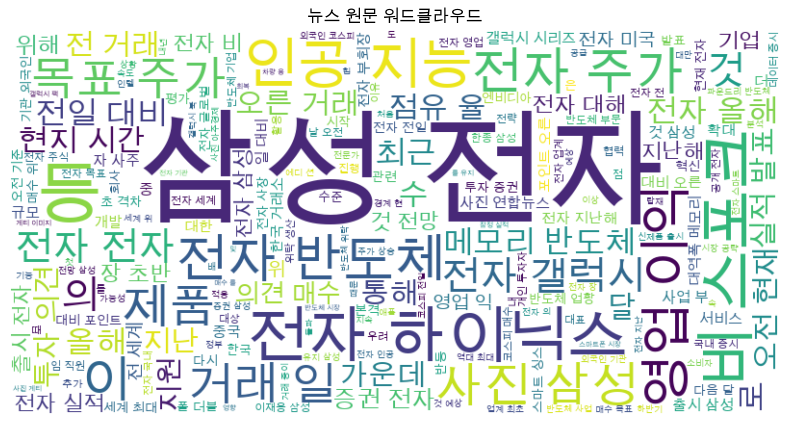

In [31]:
# 형태소 분석기
okt = Okt()

# 뉴스 원문만 추출하고 NaN제거
news_texts = df.iloc[:, 1:40].apply(lambda row : ' '.join(row.dropna().astype(str)), axis=1)
all_text = ' '.join(news_texts)

# 형태소 분석 후 명사만 추출 (조사 등 제거)
nouns = okt.nouns(all_text)
filtered_text = ' '.join(nouns)

# 워드클라우드 생성
font_path = fm.findfont("Arial Unicode MS")
wordcloud = WordCloud(font_path=font_path, background_color='white', width=800, height=400).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("뉴스 원문 워드클라우드")
plt.show()

#### TF-IDF 키워드 추출 & 트리맵 시각화
- TF : 단어가 얼마나 자주 나오는지에 대한 빈도
- IDF : 전체 문서 중 그 단어가 얼마나 희귀한지 (많이 쓰이면 가중치 낮음)

In [37]:
# 형태소 분석기
okt = Okt()

# 뉴스 원문 텍스트 → 명사 기반 문서화
documents = []
for _, row in df.iloc[:, 1:40].iterrows():
    text = ' '.join(row.dropna().astype(str))  # NaN 제거 + 문자열 결합
    nouns = okt.nouns(text)                    # 명사 추출
    documents.append(' '.join(nouns))          # 공백으로 다시 결합

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=50)
tfidf_matrix = vectorizer.fit_transform(documents)

# 키워드와 점수 추출
keywords = vectorizer.get_feature_names_out()
scores = tfidf_matrix.sum(axis=0).A1

# DataFrame으로 변환 후 상위 20개 추출
tfidf_df = pd.DataFrame({'keyword': keywords, 'score': scores})
tfidf_df = tfidf_df.sort_values(by='score', ascending=False).head(20)

# 회사명과 빈도수를 함께 보여줄 텍스트 생성
tfidf_df['label'] = tfidf_df['keyword'] + ' (' + tfidf_df['score'].astype(str) + ')'

# 트리맵 시각화
plt.figure(figsize=(12, 8))
fig = px.treemap(tfidf_df, 
                 path=['label'], # 각 사각형의 이름
                 values='score', # 크기 기준
                 color='score', # 색상 기준
                 color_continuous_scale='RdBu',  # 색상 스케일 설정
                )

fig.update_layout(
    width=800,
    height=600,
    margin=dict(t=50, l=25, r=25, b=25),
    uniformtext=dict(minsize=20, mode='show')
)

fig.show()

<Figure size 1200x800 with 0 Axes>

- 기업명 단어 등장 빈도수 분석

In [38]:
tmp_df7 = deepcopy(df)

# 형태소 분석기 초기화
okt = Okt()

# 기업명 후보 추출용 변수 초기화
all_nouns = []
entity_counts = []

# 불용어/제외어 (분석 대상 등)
stopwords = ['삼성', '삼성전자']

# 상장기업 리스트 (샘플)
known_companies = {'네이버', '카카오', 'LG전자', '현대자동차', '기아', '롯데', 'SK하이닉스', '하이닉스', '한화', '코스피', '엔비디아', 'nvidia', 'NVIDIA', 'tsmc', 'TSMC', '애플', 'Apple'}

# 기업명 후보 추출 루프
for row in tmp_df7.iloc[:, 1:40].fillna('').astype(str).values:
    text = ' '.join(row)
    nouns = okt.nouns(text)

    filtered = [n for n in nouns if len(n) > 1 and n not in stopwords]

    all_nouns.extend(filtered)
    matched = [n for n in filtered if n in known_companies]

    entity_counts.append(len(matched))

# 기업명 카운트: known_companies에 있는 항목만 필터링
known_entity_counts = Counter([n for n in all_nouns if n in known_companies])

# DataFrame에 반영
tmp_df7['other_org_count'] = entity_counts

# 출력
print("상위 기업명 후보 (known_companies 기준):")
for word, count in known_entity_counts.most_common():
    print(f"{word}: {count}")

# 트리맵 시각화
# Counter 객체 → DataFrame 변환
company_df = pd.DataFrame(known_entity_counts.items(), columns=['company', 'score'])

# 회사명과 빈도수를 함께 보여줄 텍스트 생성
company_df['label'] = company_df['company'] + ' (' + company_df['score'].astype(str) + ')'

# 트리맵 시각화 (Plotly)
fig = px.treemap(
    company_df,
    path=['label'],       # 각 사각형의 이름
    values='score',         # 크기 기준
    color='score',          # 색상 기준
    color_continuous_scale='RdBu',  # 색상 스케일 설정
    title='뉴스 기사에 등장한 주요 기업명 빈도수 (Treemap)'
)

fig.update_layout(
    width=800,
    height=600,
    margin=dict(t=50, l=25, r=25, b=25),
    uniformtext=dict(minsize=20, mode='show')
)

fig.show()

상위 기업명 후보 (known_companies 기준):
하이닉스: 1470
코스피: 1366
엔비디아: 363
애플: 336
네이버: 167
카카오: 116
기아: 78
한화: 63
롯데: 50


- 상승일/하락일 기사의 뉴스 기사 상위 키워드 분석
    - 상승/하락일 기반 2-gram TF-IDF 키워드 분석 -> 상승/하락 문맥의 감정 차이 분석

In [34]:
oct = Okt()

def prepare_documents(sub_df):
    documents = []
    for _, row in sub_df.iloc[:, 1:40].iterrows():
        text = ' '.join(row.dropna().astype(str))
        nouns = okt.nouns(text)
        documents.append(' '.join(nouns))
    return documents

# 상승일/하락일 분할
df_rise = df[df['label'] == 1]
df_fall = df[df['label'] == 0]

rise_docs = prepare_documents(df_rise)
fall_docs = prepare_documents(df_fall)

# 2-gram 기반 벡터라이저 설정
vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=30)

# 상승일 분석
rise_matrix = vectorizer.fit_transform(rise_docs)
rise_keywords = vectorizer.get_feature_names_out()
rise_scores = rise_matrix.sum(axis=0).A1
rise_result = sorted(zip(rise_keywords, rise_scores), key=lambda x: x[1], reverse=True)

print("상승일 주요 2-gram:")
for word, score in rise_result:
    print(f"{word}: {score:.2f}")

# 하락일 분석
vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=30)
fall_matrix = vectorizer.fit_transform(fall_docs)
fall_keywords = vectorizer.get_feature_names_out()
fall_scores = fall_matrix.sum(axis=0).A1
fall_result = sorted(zip(fall_keywords, fall_scores), key=lambda x: x[1], reverse=True)

print("\n하락/유지일 주요 2-gram:")
for word, score in fall_result:
    print(f"{word}: {score:.2f}")

📈 상승일 주요 2-gram:
삼성 전자: 341.79
전자 하이닉스: 41.46
인공 지능: 35.33
전자 반도체: 31.43
전자 주가: 27.71
전자 갤럭시: 25.53
전자 전자: 25.48
사진 삼성: 25.36
목표 주가: 23.30
출시 전자: 22.41
현지 시간: 20.45
갤럭시 시리즈: 20.38
메모리 반도체: 19.83
전자 삼성: 19.19
전자 스포크: 18.23
전자 올해: 17.81
전일 대비: 17.79
영업 이익: 17.45
전자 미국: 17.33
전자 세계: 17.16
출시 삼성: 16.62
전자 부회장: 16.34
세계 최대: 16.00
오른 거래: 15.60
투자 의견: 14.76
의견 매수: 14.37
오전 현재: 13.88
전자 대해: 13.24
포인트 오른: 12.68
증권 전자: 12.60

📉 하락/유지일 주요 2-gram:
삼성 전자: 725.27
전자 하이닉스: 99.63
인공 지능: 65.66
전자 갤럭시: 60.83
전자 반도체: 59.21
전자 주가: 57.19
전자 전자: 52.32
사진 삼성: 49.56
영업 이익: 48.14
목표 주가: 45.79
현지 시간: 41.74
전자 올해: 39.70
메모리 반도체: 39.54
전자 삼성: 36.97
전일 대비: 34.63
전자 미국: 33.41
전자 스포크: 33.32
갤럭시 시리즈: 33.11
실적 발표: 32.91
오른 거래: 32.46
투자 의견: 29.86
증권 전자: 29.66
사진 연합뉴스: 29.11
전자 대해: 28.87
의견 매수: 27.69
오전 현재: 27.61
전자 지난해: 27.25
전자 실적: 26.89
대비 오른: 26.28
대역폭 메모리: 26.03


- 상승/하락일 기반 감성어 빈도 분석
    - 감성어 필터 사전 정의

In [36]:
# 감성어 사전 정의
positive_words = ['상승', '호조', '기대', '강세', '호재', '개선', '돌파', '급등', '호황', '확대']
negative_words = ['하락', '우려', '약세', '감소', '둔화', '실망', '위기', '축소', '급락', '불안']

# 뉴스 문서 전처리 함수
def prepare_documents(sub_df):
    documents = []
    for _, row in sub_df.iloc[:, 1:40].iterrows():
        text = ' '.join(row.dropna().astype(str))
        documents.append(text)
    return documents

rise_docs = prepare_documents(df[df['label'] == 1])
fall_docs = prepare_documents(df[df['label'] == 0])

# 감성어 빈도 세기 함수
def count_sentiment_terms(docs, word_list):
    return sum(text.count(word) for text in docs for word in word_list)

print("상승일 감성어 등장 빈도")
print("긍정 단어 빈도:", count_sentiment_terms(rise_docs, positive_words))
print("부정 단어 빈도:", count_sentiment_terms(rise_docs, negative_words))

print("\n하락/유지일 감성어 등장 빈도")
print("긍정 단어 빈도:", count_sentiment_terms(fall_docs, positive_words))
print("부정 단어 빈도:", count_sentiment_terms(fall_docs, negative_words))

상승일 감성어 등장 빈도
긍정 단어 빈도: 1445
부정 단어 빈도: 711

하락/유지일 감성어 등장 빈도
긍정 단어 빈도: 2634
부정 단어 빈도: 1692


# 5. 주가 데이터 분석

#### 1. 시계열 분해 (Time Series Decomposition)
1) **추세 (Trend)**
- 장기적인 방향성
- 시간이 지남에 따라 장기적으로 데이터가 상승하거나 하락하는 경향을 보여줌

2) **계절성(Seasonality)**
- 일정 주기로 반복되는 패턴 ex) 분기별 실적 발표에 따른 주가 변동
- 주식시장에서는 월말 효과, 배당 발표, 분기 실적 등과 관련 있음

3) **잔차(Residual / Noise)**
- 추세나 계절성으로 설명되지 않는 비정형적인 변동. 즉, 예상 밖의 움직임 ex) 갑작스러운 뉴스 이슈, 예기치 못한 시장 반응 

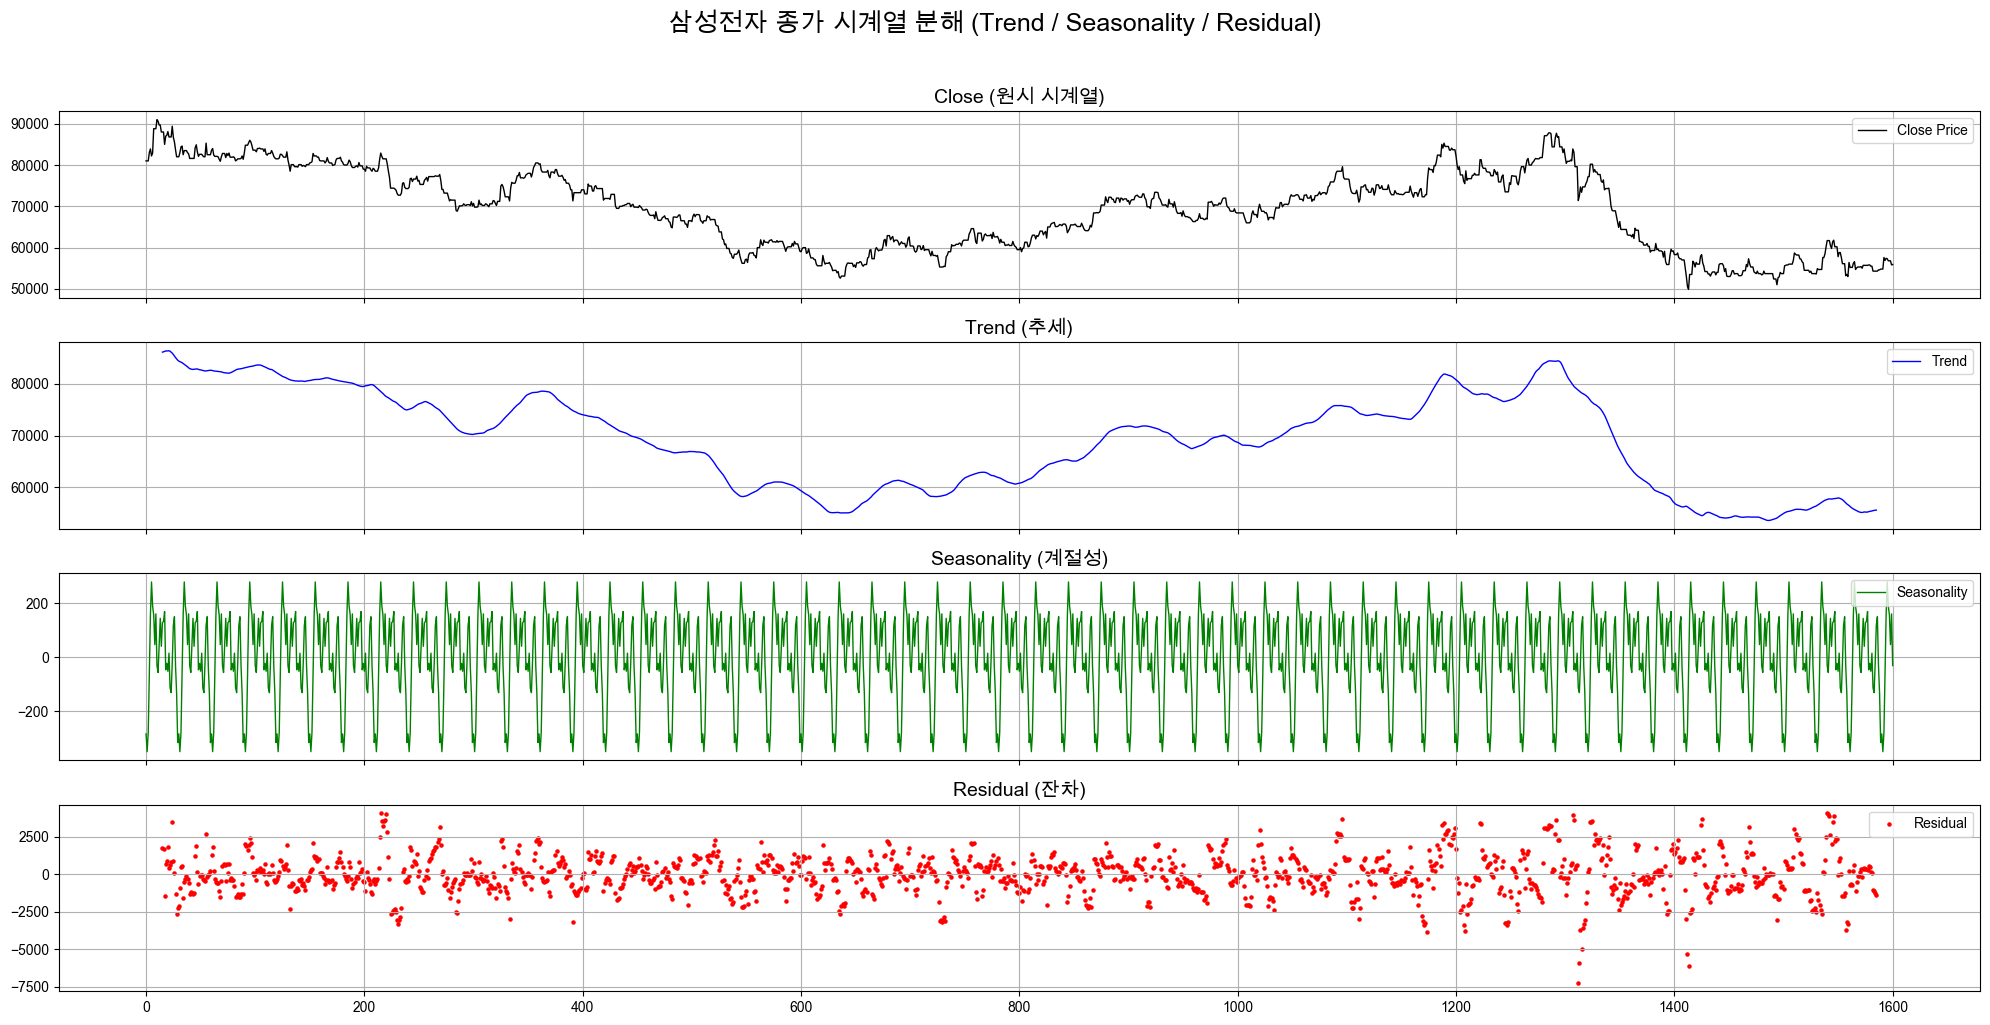

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

tmp_df9 = deepcopy(df)

# 시계열 분해
result = seasonal_decompose(tmp_df9['close'], model='additive', period=30)  # 월 단위 계절성을 가정

# 시각화
fig, axs = plt.subplots(4, 1, figsize=(20, 10), sharex=True)

axs[0].plot(result.observed, label='Close Price', color='black', linewidth=1)
axs[0].set_title('Close (원시 시계열)', fontsize=14)

axs[1].plot(result.trend, label='Trend', color='blue', linewidth=1)
axs[1].set_title('Trend (추세)', fontsize=14)

axs[2].plot(result.seasonal, label='Seasonality', color='green', linewidth=1)
axs[2].set_title('Seasonality (계절성)', fontsize=14)

axs[3].scatter(result.resid.index, result.resid, label='Residual', color='red', s=5)
axs[3].set_title('Residual (잔차)', fontsize=14)

for ax in axs:
    ax.grid(True)
    ax.legend()

fig.suptitle('삼성전자 종가 시계열 분해 (Trend / Seasonality / Residual)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# 각 성분 추출
trend = result.trend
seasonal = result.seasonal
resid = result.resid

##### (1) Close (원시 시계열)
- 단기적으로 오르고 내리는 작은 파동이 반복됨
- 중간쯤부터는 큰 폭의 하락과 상승이 번갈아 나타나는 복합적인 흐름을 보여줌
##### (2) Trend (추세)
- 초반엔 8만 원대에서 시작해 서서히 하락
- 중반부에 잠시 반등
- 다시 하락하여 현재는 6만 원대 수준
    - 1~2년간 뉴스가 계속 긍정적이고 실적이 좋다면 상승 추세
    - 글로벌 반도체 수요 감소, 수출 규제 등 악재가 누적되면 하락 추세
##### (3) Seansonality (계절성)
- 주기가 매우 뚜렷한 반복 형태로 나타남 (30일 주기)
- 고점과 저점의 간격이 일정한 파형 형태 : 주가가 반복되는 패턴 때문에 평균에서 얼마만큼 위/아래로 벗어나는가
- 양수 -> 그날은 평균보다 높게 움직이는 경향이 있음 (y=+200 : 주기적 패턴 때문에 종가가 평균보다 200원 높아질 경향이 있는 날)
- 음수 -> 그날은 평균보다 낮게 움직이는 경향이 있음 (y=-150 : 주기적 패턴 때문에 종가가 평균보다 150원 낮아질 경향이 있는 날)
    - 예시 계절성 : "삼성전자는 실적 발표 전날에 주가가 오른다."
##### (4) Residual (잔차)
- 잔차 = 원시 close값 - (추세 + 계절성)
- y축 절댓값이 클수록, 해당 날짜의 종가는 예측보다 크게 벗어난 것
- 대부분의 점이 0에 몰려있음
- 특정 지점에서 큰 폭으로 튀는 점들(outlier) 존재
    - 갑작스러운 뉴스(반도체 공급 차질, 갑작스러운 CEO 교체 등)로 인한 주가 급변 -> 잔차로 표햔됨

#### 2. 변동성 (Volatility) 분석
- 주가의 일일 가격 변동폭과 뉴스의 감성 변화와의 관계 파악
- 뉴스 기사 개수 구간별 가격 변동폭 확인

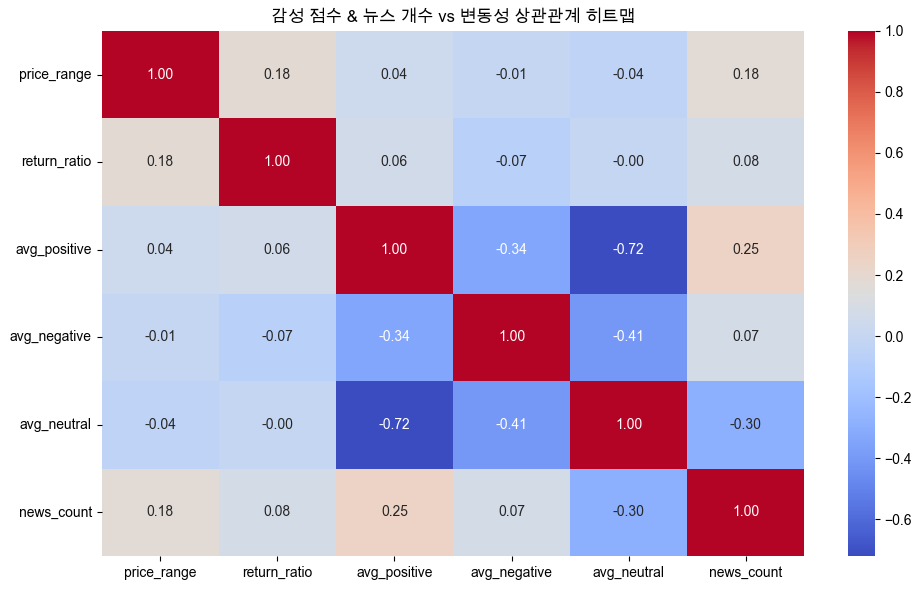

In [39]:
df_vol = deepcopy(df)  # 원본 훼손 방지

# 변동폭(고가-저가) 및 수익률 파생 변수 생성
df_vol['price_range'] = df_vol['high'] - df_vol['low']
df_vol['return_ratio'] = (df_vol['close'] - df_vol['open']) / df_vol['open']

# 상관관계 분석 대상 컬럼
cor_cols = ['price_range', 'return_ratio', 'avg_positive', 'avg_negative', 'avg_neutral', 'news_count']

# 상관행렬 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(df_vol[cor_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('감성 점수 & 뉴스 개수 vs 변동성 상관관계 히트맵')
plt.tight_layout()
plt.show()

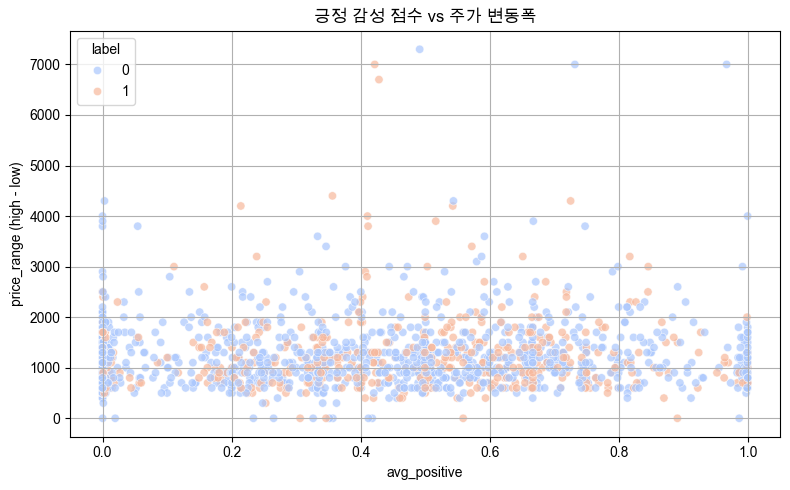

In [ ]:
# 긍정 감성 vs 변동폭
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_vol, x='avg_positive', y='price_range', hue='label', palette='coolwarm', alpha=0.7)
plt.title('긍정 감성 점수 vs 주가 변동폭')
plt.xlabel('avg_positive')
plt.ylabel('price_range (high - low)')
plt.grid(True)
plt.tight_layout()
plt.show()

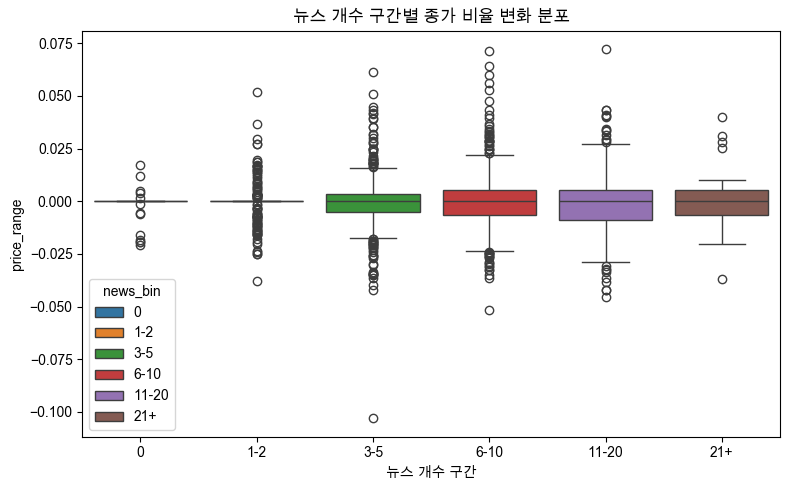

In [60]:
# 뉴스 개수를 bin으로 나누어 보기 (예: 0~2건, 3~5건, ...)
df_vol['prev_news_count'] = df_vol['news_count'].shift(1)
df_vol['close_diff'] = df_vol['close'] - df_vol['close'].shift(1)
df_vol['close_ratio'] = (df_vol['close'] - df_vol['close'].shift(1)) / df_vol['close'].shift(1)

df_vol['news_bin'] = pd.cut(df_vol['prev_news_count'], bins=[-1, 0, 2, 5, 10, 20, 50],
                             labels=['0', '1-2', '3-5', '6-10', '11-20', '21+'])

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_vol, x='news_bin', y='close_ratio', hue='news_bin')
plt.title('뉴스 개수 구간별 종가 비율 변화 분포')
plt.xlabel('뉴스 개수 구간')
plt.ylabel('price_range')
plt.tight_layout()
plt.show()

**1. 뉴스가 없는 날 (0건)**
- 중앙값이 거의 0에 가깝고, IQR도 좁음
    - 뉴스가 없던 전날 이후에는 주가가 큰 폭으로 움직이지 않는 경향이 있음.

**2. 뉴스 개수 1-2 ~ 3-5건**
- 분포가 0을 중심으로 대칭적이고 약간 확산됨
    - 뉴스가 몇 건 있는 날은 주가 변화에 어느 정도 영향을줄 가능성이 있음.

**3. 뉴스 개수 6-10 ~ 11-20건**
- 전체 박스(변동성 범위)가 넓어짐
    - 즉, 전날 뉴스가 많을수록 다음날 주가 변화 폭도 커지는 경향

**이상치(Outlier)**
- 각 구간에서 위아래로 퍼진 동그라미들은 급격한 주가 상승 또는 하락 사례
- 특히 뉴스가 많은 날에도 이상치가 많음

#### 3. 뉴스 수(news_count)와 주가 변화 간 관계 분석
- 전날 뉴스가 많을수록 다음날 주가에 어떤 영향을 미치는지를 파악
    - 뉴스량이 많을수록 주가가 더 크게 움직이는가?
    - 상승할 확률이 높아지는가?

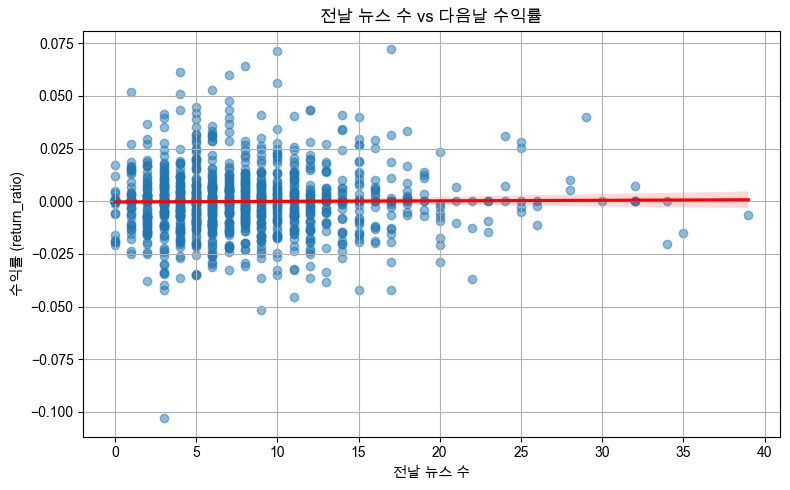

In [55]:
df_news = deepcopy(df).sort_values('date').reset_index(drop=True)

# 전날 뉴스 수
df_news['prev_news_count'] = df_news['news_count'].shift(1)

# 수익률 및 변동폭
df_news['return_ratio'] = (df_news['close'] - df_news['close'].shift(1)) / df_news['close'].shift(1)
df_news['abs_return_ratio'] = df_news['return_ratio'].abs()

plt.figure(figsize=(8,5))
sns.regplot(data=df_news, x='prev_news_count', y='return_ratio', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('전날 뉴스 수 vs 다음날 수익률')
plt.xlabel('전날 뉴스 수')
plt.ylabel('수익률 (return_ratio)')
plt.grid(True)
plt.tight_layout()
plt.show()

- 붉은 회귀선 : 기울기 약 0
    - 전날 뉴스 수가 많아진다고 해서 다음날 수익률이 일관되게 상승하거나 하락하는 패턴은 없음

- 뉴스 수가 적은 경우 (0~10개)
    - 데이터 포인트가 가장 밀집되어 있음
    - 수익률이 +-3% 사이에 대부분 존재
    - 뉴스가 몇 건만 있었던 날도 큰 수익률 변동이 발생하는 경우는 일부 존재, 그러나 대부분은 작은 변동에 그침

- 뉴스 수가 많은 경우 (20개 이상)
    - 데이터 포인트 수가 급격히 감소
    - 산점도가 퍼지지 않고 거의 0 근처에 밀집됨
    - 뉴스가 30개 이상인 날은 오히려 큰 변화 없이 정체된 반응을 보일 가능성을 시사

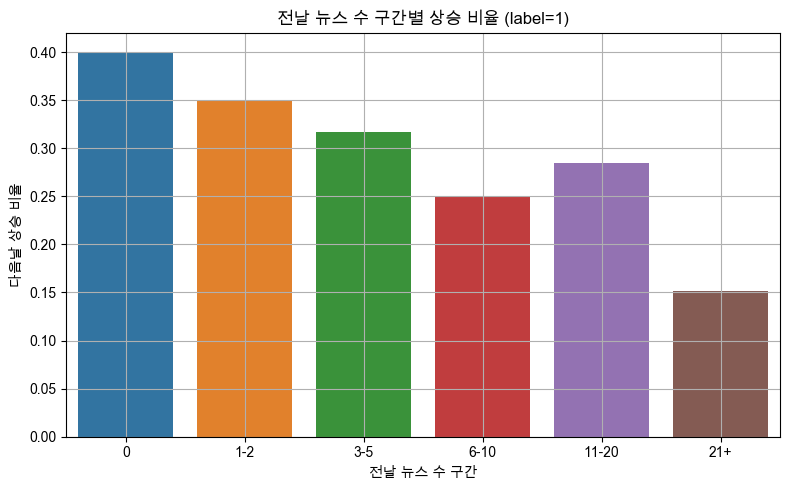

In [59]:
# 구간화
df_news['news_bin'] = pd.cut(df_news['prev_news_count'], bins=[-1,0,2,5,10,20,50],
                             labels=['0','1-2','3-5','6-10','11-20','21+'])

# label=1 비율 계산
label_stats = df_news.groupby('news_bin')['label'].agg(['mean', 'count']).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=label_stats, x='news_bin', y='mean', hue='news_bin')
plt.title('전날 뉴스 수 구간별 상승 비율 (label=1)')
plt.xlabel('전날 뉴스 수 구간')
plt.ylabel('다음날 상승 비율')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 4. 감성 점수와 주가의 시차 상관 분석
- 뉴스의 감섬 점수가 당일이 아니라 며칠 후 주가에 영향을 주는지 파악
    - 감성 -> 주가 반영이 며칠의 시차(Lag)를 두고 나타나는가?
    - 예측 시점(t+1, t+2, ...)에서 감성 데이터를 활용할 수 있는가?

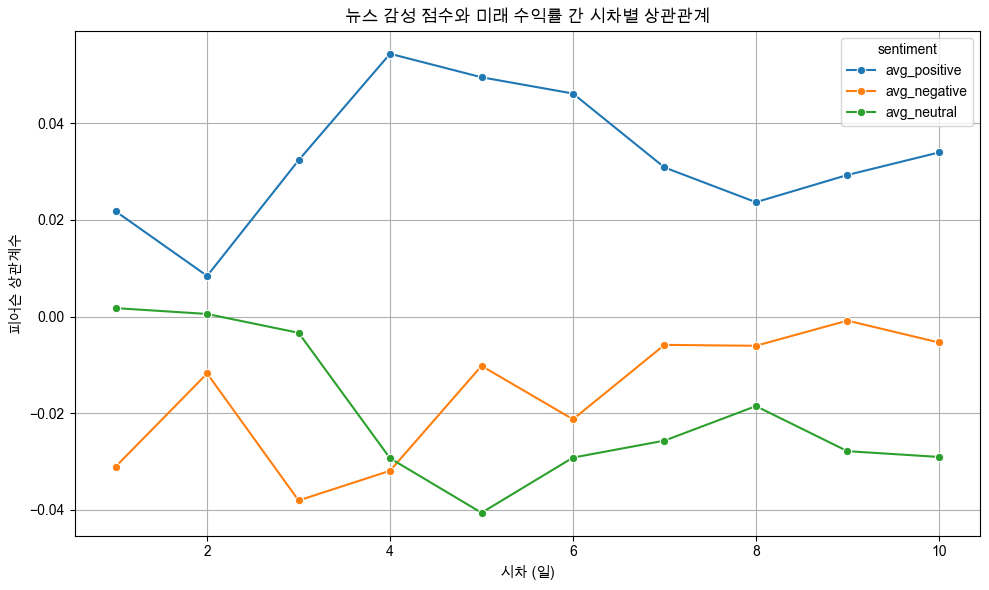

In [54]:
from scipy.stats import pearsonr

df_lag = deepcopy(df)
df_lag = df_lag.sort_values('date').reset_index(drop=True)

# 시차를 줄 범위 설정 (1~5일 후까지)
max_lag = 10

# 시차에 따른 종가 변화와 수익률 생성
for lag in range(1, max_lag + 1):
    df_lag[f'close_lag_{lag}'] = df_lag['close'].shift(-lag)
    df_lag[f'return_ratio_lag_{lag}'] = (df_lag[f'close_lag_{lag}'] - df_lag['close']) / df_lag['close']

# 감성 점수 vs 미래 주가 변화 상관관계 계산
correlation_results = []

for lag in range(1, max_lag + 1):
    for sentiment in ['avg_positive', 'avg_negative', 'avg_neutral']:
        # NaN 제외하고 상관계수 계산
        df_temp = df_lag[[sentiment, f'return_ratio_lag_{lag}']].dropna()
        corr, pval = pearsonr(df_temp[sentiment], df_temp[f'return_ratio_lag_{lag}'])
        correlation_results.append({
            'sentiment': sentiment,
            'lag': lag,
            'correlation': corr,
            'p_value': pval
        })

corr_df = pd.DataFrame(correlation_results)

# 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=corr_df, x='lag', y='correlation', hue='sentiment', marker='o')
plt.title('뉴스 감성 점수와 미래 수익률 간 시차별 상관관계')
plt.xlabel('시차 (일)')
plt.ylabel('피어슨 상관계수')
plt.grid(True)
plt.tight_layout()
plt.show()


**1. avg_positive**
- 상관계수는 `lag=1`부터 지속적으로 증가
- `lag=5`일에서 최고치 (약 0.05)
    - 긍정 뉴스가 나타난 후 3~5일 사이에 주가가 상승할 가능성이 약하게 존재

**2. avg_negative**
- 상관계수는 음수 영역에 있음
- `lag=3`에서 -0.04 수준의 최저치
    - 부정 뉴스가 일정 시차를 두고 하락과 연관이 있으나 일관되지 않고 상관성이 약함

**3. avg_neutral**
- 전반적으로 상관계수가 0에 가깝고 낮음
- `lag=4~5`일에서 마이너스 영역으로 소폭 하락
    - 중립 뉴스는 주가 방향성과 직접적인 관계가 거의 없음을 시사

#### 5. 골든크로스 포인트 파악
- 이동평균 (Moving Average, MA) : 특정 기간 동안의 평균 주가 계산
    - 5일 이동평균(MA 5) : 최근 5일 동안의 종가 평균


- 골든 크로스(Golden Cross) : 단기 이동 평균선(MA 5)이 장기 이동평균선(MA 20)을 아래에서 위로 뚫고 올라갈 때 발생하는 신호로, "상승 추세 시작"을 의미하는 대표적 매수 신호
- 데드 크로스(Death Cross) : 반대로 단기 이동 평균선이 장기선을 아래로 뚫고 내려가는 경우, 매도 신호

<Figure size 1400x600 with 0 Axes>

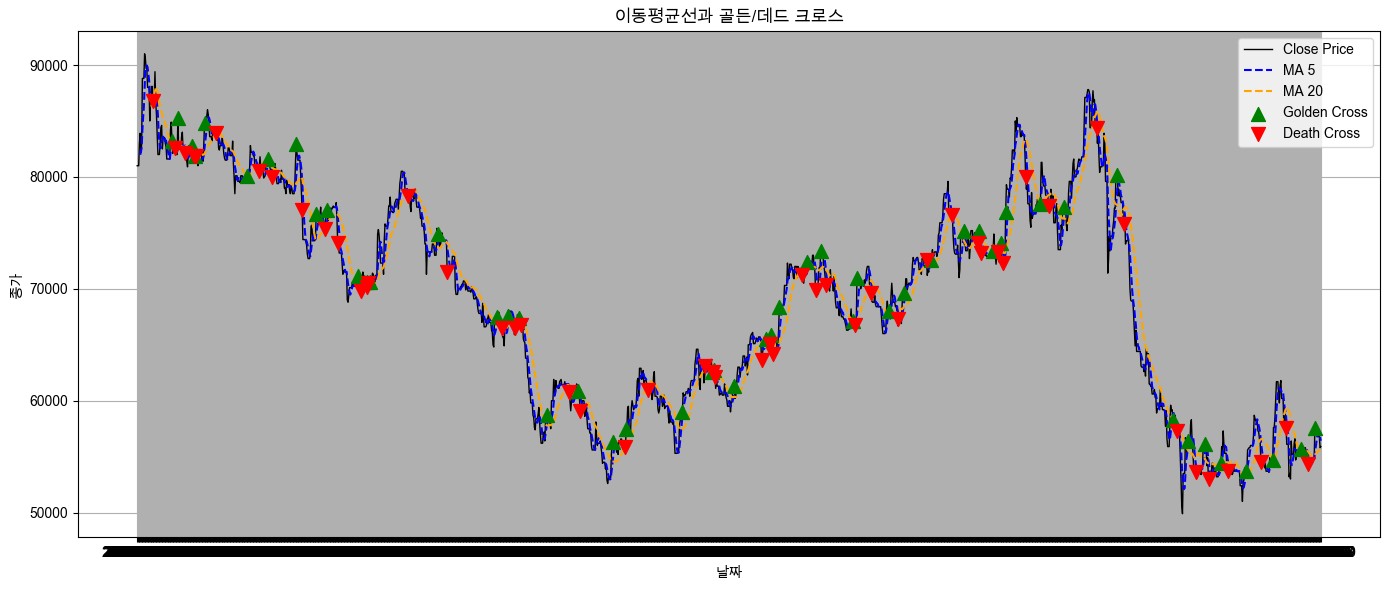

In [52]:
# 이동평균선 계산
df_ma = deepcopy(df)

# 이동평균선 계산
df_ma['MA_5'] = df_ma['close'].rolling(window=5).mean()
df_ma['MA_20'] = df_ma['close'].rolling(window=20).mean()

# 골든크로스: MA_5가 아래에서 MA_20을 뚫고 올라갈 때
df_ma['golden_cross'] = (df_ma['MA_5'] > df_ma['MA_20']) & (df_ma['MA_5'].shift(1) <= df_ma['MA_20'].shift(1))

# 데드크로스: MA_5가 위에서 MA_20을 뚫고 내려갈 때
df_ma['death_cross'] = (df_ma['MA_5'] < df_ma['MA_20']) & (df_ma['MA_5'].shift(1) >= df_ma['MA_20'].shift(1))

plt.figure(figsize=(14, 6))

# 골든/데드 크로스 포인트 추출
golden_points = df_ma[df_ma['golden_cross']]
death_points = df_ma[df_ma['death_cross']]

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(df_ma['date'], df_ma['close'], label='Close Price', color='black', linewidth=1)
plt.plot(df_ma['date'], df_ma['MA_5'], label='MA 5', color='blue', linestyle='--')
plt.plot(df_ma['date'], df_ma['MA_20'], label='MA 20', color='orange', linestyle='--')

# 마커 표시
plt.scatter(golden_points['date'], golden_points['close'],
            label='Golden Cross', color='green', marker='^', s=100, zorder=5)
plt.scatter(death_points['date'], death_points['close'],
            label='Death Cross', color='red', marker='v', s=100, zorder=5)

plt.title('이동평균선과 골든/데드 크로스')
plt.xlabel('날짜')
plt.ylabel('종가')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**1. 크로스 이벤트 분포**
- 초록색 골든크로스 마커와 빨간색 데드크로스 마커가 주기적으로 반복적으로 등장
- 이는 삼성전자 주가가 일정한 흐름을 가지기보다는, 단기 추세가 반복적으로 꺾이고 반등하는 구조임을 보여줌

**2. 골든크로스 후 상승 흐름 존재 여부**
- 일부 구간에서는 골든크로스 이후 실제로 주가가 반등하여 상승하는 구간 존재
- 일부는 크로스 직후 하락세로 전환되는 구간도 보임
    - 골든크로스가 항상 상승을 의미하진 않음

**3. 데드크로스 후 하락 흐름**
- 데드크로스 직후 주가 하락이 관찰되는 구간도 다수 존재
- 특히 큰 하락 추세의 전환점에서 데드크로스가 강하게 등장
    - 데드크로스는 상대적으로 더 강한 하락 신호로 작용하는 경향

#### avg_positive 시계열에서 변화율이 급격히 달라진 지점 탐색
- z-score 활용
    - z-score : 하나의 데이터가 전체 평균에서 얼마나 떨어져 있는지를 표준편차 단위로 표현한 값
    - z-score가 클수록 평균에서 멀리 떨어진 값
- 평균과 표준편차를 기준으로 변화율이 비정상적으로 큰 날을 포착

이상적으로 변화가 큰 날짜들:
[Timestamp('2021-01-02 00:00:00'), Timestamp('2021-02-20 00:00:00'), Timestamp('2021-02-21 00:00:00'), Timestamp('2021-03-28 00:00:00'), Timestamp('2022-02-23 00:00:00'), Timestamp('2022-05-29 00:00:00'), Timestamp('2022-07-24 00:00:00'), Timestamp('2022-10-09 00:00:00'), Timestamp('2023-02-22 00:00:00'), Timestamp('2023-05-13 00:00:00'), Timestamp('2023-07-23 00:00:00'), Timestamp('2023-08-11 00:00:00'), Timestamp('2023-08-12 00:00:00'), Timestamp('2023-08-20 00:00:00'), Timestamp('2023-09-09 00:00:00'), Timestamp('2023-09-28 00:00:00'), Timestamp('2023-10-14 00:00:00'), Timestamp('2023-10-15 00:00:00'), Timestamp('2023-11-05 00:00:00'), Timestamp('2023-12-02 00:00:00'), Timestamp('2023-12-09 00:00:00'), Timestamp('2024-02-04 00:00:00'), Timestamp('2024-02-18 00:00:00'), Timestamp('2024-05-18 00:00:00'), Timestamp('2024-07-27 00:00:00'), Timestamp('2024-09-15 00:00:00'), Timestamp('2024-09-30 00:00:00'), Timestamp('2024-12-08 00:00:00'), Timestamp('2024-12-09 00:00:00

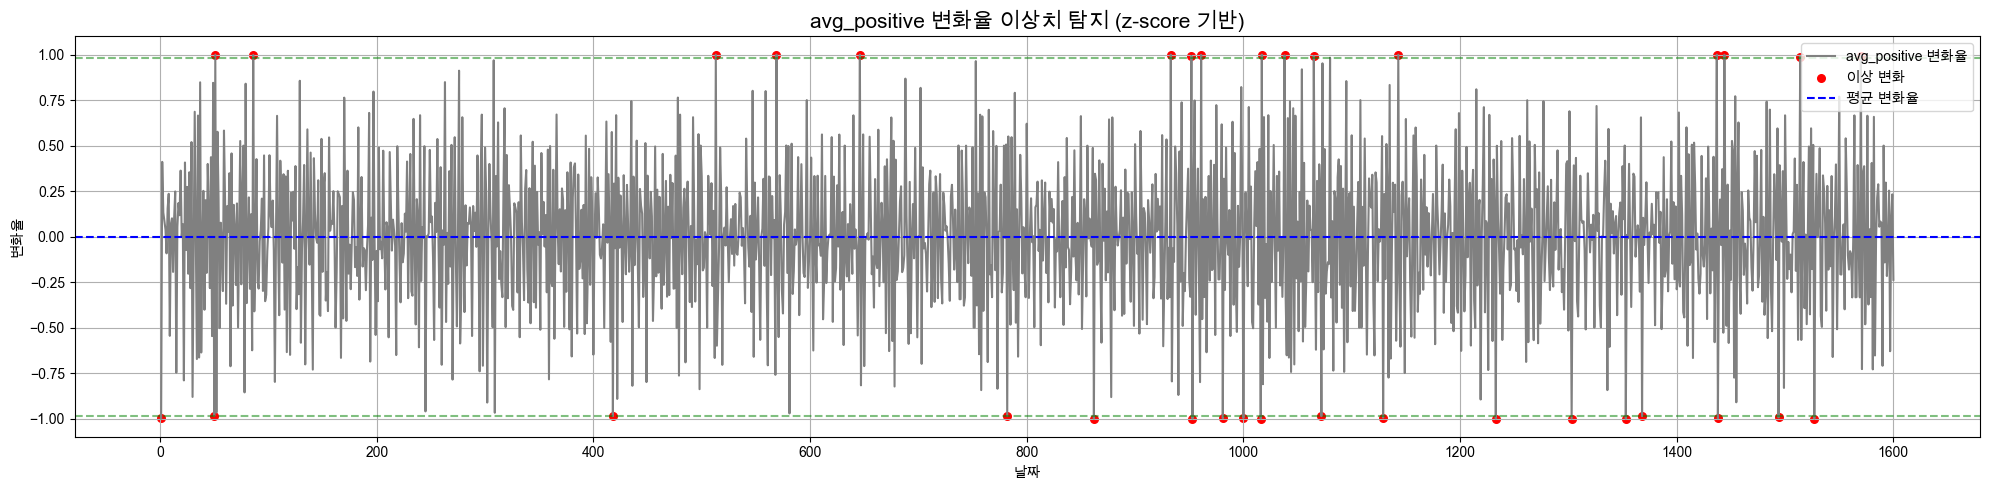

In [38]:
tmp_df10 = deepcopy(df)

# 1. 결측치 처리
tmp_df10['avg_positive'] = tmp_df10['avg_positive'].fillna(0)

# 2. 1차 차분 → 변화율 계산
tmp_df10['pos_diff'] = tmp_df10['avg_positive'].diff()

# 3. 평균과 표준편차
mean_diff = tmp_df10['pos_diff'].mean()
std_diff = tmp_df10['pos_diff'].std()

# 4. Z-score 계산
tmp_df10['z_score'] = (tmp_df10['pos_diff'] - mean_diff) / std_diff

# 5. 임계값 설정 (|z| > 2.5 → 통상 이상치로 간주)
threshold = 2.5
tmp_df10['is_outlier'] = tmp_df10['z_score'].abs() > threshold

# 6. 이상 변화율 발생 날짜 출력
outlier_dates = tmp_df10[tmp_df10['is_outlier']].index

outlier_dates_list = list(tmp_df10.iloc[outlier_dates]['date'])
print("이상적으로 변화가 큰 날짜들:")
print(outlier_dates_list)

# 7. 시각화
plt.figure(figsize=(20, 5))
plt.plot(tmp_df10.index, tmp_df10['pos_diff'], label='avg_positive 변화율', color='gray')
plt.scatter(tmp_df10[tmp_df10['is_outlier']].index, tmp_df10[tmp_df10['is_outlier']]['pos_diff'],
            color='red', label='이상 변화', s=30)
plt.axhline(mean_diff, color='blue', linestyle='--', label='평균 변화율')
plt.axhline(mean_diff + threshold * std_diff, color='green', linestyle='--', alpha=0.5)
plt.axhline(mean_diff - threshold * std_diff, color='green', linestyle='--', alpha=0.5)
plt.title('avg_positive 변화율 이상치 탐지 (z-score 기반)', fontsize=15)
plt.xlabel('날짜')
plt.ylabel('변화율')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- 이상치 기준 : z-score ≥ 2.5 또는 ≤ -2.5
    - 정규분포 상위/하위 0.6% 정도 되는 극단적인 값
    - 실제로는 전체 중 약 1~2% 미만의 데이터만 이상치로 탐지됨

- 회색선 : avg_positive의 일일 변화율
- 빨간점 : ±2.5σ 이상 벗어난 이상치 날짜 = 전날에 비해 감성 점수가 급격히 변했음
- 파란 점선 : 평균 변화율 (대부분 0 근처)
- 초록 점선 : ±2.5σ 경계선 -> 이 선을 넘으면 이상치로 간주

##### 변화율이 급격한 날짜의 뉴스 원문 분석

In [39]:
# 뉴스 본문 컬럼만 추출
news_cols = [col for col in tmp_df10.columns if str(col).isdigit()]

# 이상치 날짜 datetime 형변환
outlier_dates_dt = pd.to_datetime(outlier_dates_list)

# 이상치 날짜 ±1일 수집
window = 1
analyzed_news = {}

for date in outlier_dates_dt:
    start = date - timedelta(days=window)
    end = date + timedelta(days=window)

    # 'date' 컬럼을 기준으로 필터링
    mask = (pd.to_datetime(tmp_df10['date']) >= start) & (pd.to_datetime(tmp_df10['date']) <= end)
    news_window = tmp_df10.loc[mask, news_cols]

    # 뉴스 본문 추출 (빈 셀 제거)
    news_texts = news_window.values.flatten()
    news_texts = [text for text in news_texts if isinstance(text, str) and text.strip() != '']

    # 해당일의 pos_diff, close, label 값
    pos_diff = tmp_df10[tmp_df10['date'] == date.strftime('%Y-%m-%d')]['pos_diff'].item()
    close = tmp_df10[tmp_df10['date'] == date.strftime('%Y-%m-%d')]['close'].item()
    label = tmp_df10[tmp_df10['date'] == date.strftime('%Y-%m-%d')]['label'].item()

    analyzed_news[date.strftime('%Y-%m-%d')] = {'news_texts' : news_texts,
                                                'pos_diff' : pos_diff,
                                                'close' : close,
                                                'label' : label}

# 간단 확인
for date, data in analyzed_news.items():
    print(f"\n{date} : avg_positive 변화량 = {data['pos_diff']}, 종가(close) = {data['close']}, 다음날 등락 : {data['label']}, 전후 뉴스 요약 ({len(data)}건):")
    for i, text in enumerate(data['news_texts'][:3]):    # 상위 3개만 출력(단순 앞에서 3개만 보여줌)
        print(f" - 뉴스 {i+1}: {text[:100]}...")


2021-01-02 : avg_positive 변화량 = -0.9997, 종가(close) = 81000.0, 다음날 등락 : 0, 전후 뉴스 요약 (4건):
 - 뉴스 1: 아이폰12, 출시 두 달만에 삼성전자 1년치 5G폰 판매량 앞질러 ||| 아이폰12. [사진=애플 제공] 지난해 5G 스마트폰 시장에서 애플 아이폰이 삼성전자 갤럭시보다 더 많이 ...
 - 뉴스 2: "연말정산, 삼성 패스에서 하세요" 삼성전자도 민간 인증서 전쟁에 나섰다 ||| 삼성 패스 인증서.[사진=강일용 기자] 삼성전자가 이동통신 3사(PASS), 카카오, KB국민은행,...
 - 뉴스 3: 삼성전자, 비스포크 인덕션 신제품 출시…3300W ‘최고 화력’ ||| 삼성전자가 차별화된 디자인과 국내 최고 수준의 화력을 갖춘 ‘삼성 비스포크(BESPOKE) 인덕션’ 신제품을...

2021-02-20 : avg_positive 변화량 = -0.9856, 종가(close) = 82600.0, 다음날 등락 : 0, 전후 뉴스 요약 (4건):
 - 뉴스 1: [MBN GOLD 시황저격] 반도체 슈퍼사이클…삼성전자 기대되네 ||| 코로나19 확산세가 여전하다. 연말연초 정점을 이루었을 때 비해 글로벌 확진자 숫자가 많이 줄어들긴 했지만 ...
 - 뉴스 2: 진격의 '서학개미'…해외에서 삼성전자보다 2배 더 벌었다 [김익환의 외환·금융 워치] ||| 개인·기관이 지난해 해외 주식·펀드를 비롯한 지분증권 투자로 558억달러(약 61조73...
 - 뉴스 3: 신한운용, 삼성전자알파채권혼합형펀드 설정액 5천억 돌파 ||| 신한자산운용은 '삼성전자알파혼합형펀드' 설정액이 5000억원을 돌파했다고 19일 밝혔다. 저금리 고착화로 인해 저축에...

2021-02-21 : avg_positive 변화량 = 0.9999, 종가(close) = 82600.0, 다음날 등락 : 0, 전후 뉴스 요약 (4건):
 - 뉴스 1: 2월 경력 채용 활발...삼성전자 삼성SDI 카카오페이 모집 ||| [사진=인크

#### 가장 크게 오른 날과 가장 크게 떨어진 날 기준 전날 데이터 분석

In [77]:
df_change = deepcopy(df).sort_values('date').reset_index(drop=True)

# 수익률(%) 계산
df_change['return_ratio'] = (df_change['close'] - df_change['close'].shift(1)) / df_change['close'].shift(1)

# 최대 상승율 (비율 기준)
max_up_idx = df_change['return_ratio'].idxmax()
max_up_date = df_change.loc[max_up_idx, 'date']
max_up_ratio = df_change.loc[max_up_idx, 'return_ratio']
prev_up_row = df_change.loc[max_up_idx - 1]

# 최대 하락율
max_down_idx = df_change['return_ratio'].idxmin()
max_down_date = df_change.loc[max_down_idx, 'date']
max_down_ratio = df_change.loc[max_down_idx, 'return_ratio']
prev_down_row = df_change.loc[max_down_idx - 1]

# 뉴스 컬럼 추출
news_cols = [col for col in df_change.columns if str(col).isdigit()]

# 뉴스 추출 함수
def extract_news_texts(row):
    return [row[col] for col in news_cols if pd.notna(row[col]) and isinstance(row[col], str) and row[col].strip() != '']

# 최대 상승율 출력
print(f"\n[최대 상승율일: {max_up_date}]")
print(f"  - 수익률: +{max_up_ratio*100:.2f}%")
print(f"  → 전날 뉴스 분석일: {prev_up_row['date']}")
print(f"  - 뉴스 개수: {int(prev_up_row['news_count'])}")
print(f"  - 긍정: {prev_up_row['avg_positive']:.4f}, 중립: {prev_up_row['avg_neutral']:.4f}, 부정: {prev_up_row['avg_negative']:.4f}")
print("  - 뉴스 요약:")
for i, text in enumerate(extract_news_texts(prev_up_row)[:3]):
    print(f"    • 뉴스 {i+1}: {text[:100]}...")

# 최대 하락율 출력
print(f"\n[최대 하락율일: {max_down_date}]")
print(f"  - 수익률: {max_down_ratio*100:.2f}%")
print(f"  → 전날 뉴스 분석일: {prev_down_row['date']}")
print(f"  - 뉴스 개수: {int(prev_down_row['news_count'])}")
print(f"  - 긍정: {prev_down_row['avg_positive']:.4f}, 중립: {prev_down_row['avg_neutral']:.4f}, 부정: {prev_down_row['avg_negative']:.4f}")
print("  - 뉴스 요약:")
for i, text in enumerate(extract_news_texts(prev_down_row)[:3]):
    print(f"    • 뉴스 {i+1}: {text[:100]}...")



[최대 상승율일: 2024-11-15]
  - 수익률: +7.21%
  → 전날 뉴스 분석일: 2024-11-14
  - 뉴스 개수: 17
  - 긍정: 0.1625, 중립: 0.3210, 부정: 0.5165
  - 뉴스 요약:
    • 뉴스 1: 코스피 집어삼킨 삼성전자…자사주 소각 의무화·상법 개정 고민해야 ||| ‘나라가 망하지 않는 한 삼성전자(005930)가 무너질 일은 없다.’...
    • 뉴스 2: "삼성전자, 엔비디아 '루빈' 출시 지연은 기술격차 좁힐 기회…목표가↓"-키움 ||| 키움증권은 14일 삼성전자에 대해 좀처럼 좁혀지지 않는 고대역폭메모리(HBM) 반도체 분야의 ...
    • 뉴스 3: 키움證 "삼성전자, 메모리 가격·이익 전망치 하락에 목표가↓… D램 핵심 경쟁력 회복 시급" ||| [사진=삼성전자] 키움증권은 14일 분석 보고서를 통해 범용 메모리 가격과 20...

[최대 하락율일: 2024-08-05]
  - 수익률: -10.30%
  → 전날 뉴스 분석일: 2024-08-04
  - 뉴스 개수: 3
  - 긍정: 0.3345, 중립: 0.3333, 부정: 0.3322
  - 뉴스 요약:
    • 뉴스 1: 삼성전자 '갤럭시 스튜디오' 누적 방문객 30만명 돌파 ||| 갤럭시 스튜디오 ‘삼성스토어 홍대’에 공항 콘셉트로 꾸며진 체험공간 전경. [사진=삼성전자]삼성전자는 지난달 11일부...
    • 뉴스 2: 엔비디아 AI 가속기 결함…삼성전자 반사이익 누릴까 ||| 엔비디아가 차세대 인공지능(AI) 가속기 ‘블랙웰’ 시리즈 중 최고급 제품인 ‘GB200’의 납품 일정을 3개월 이상 연...
    • 뉴스 3: "12만 AI 전사 키우자"…'특훈' 나선 삼성전자 ||| 삼성전자가 12만 명에 달하는 국내 사업장 임직원을 대상으로 인공지능(AI) 기술 역량 강화에 나섰다. 생성형 AI와 같...


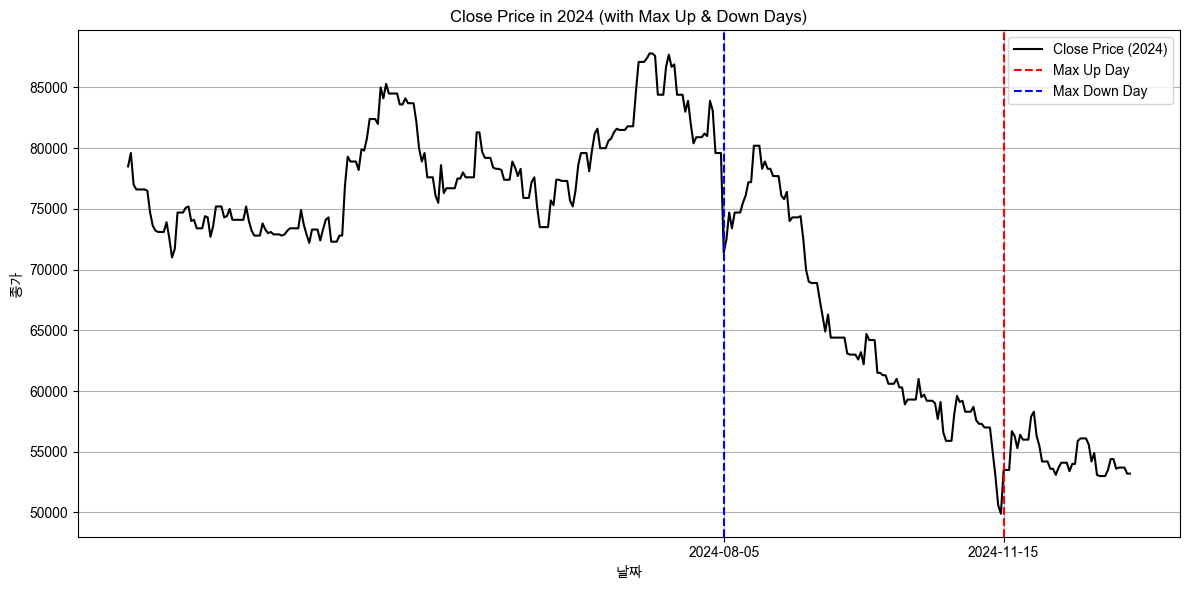

In [89]:
# 날짜 컬럼이 datetime 형식이어야 함
df['date'] = pd.to_datetime(df['date'])

# 2024년 데이터만 필터링
df_2024 = df[(df['date'] >= '2024-01-01') & (df['date'] <= '2024-12-31')].copy()

# 최대 상승/하락일 정의
max_ascending_date = pd.to_datetime("2024-11-15")
max_descending_date = pd.to_datetime("2024-08-05")

# 시각화
plt.figure(figsize=(12,6))
plt.plot(df_2024['date'], df_2024['close'], label='Close Price (2024)', color='black')

# 수직선 표시
plt.axvline(max_ascending_date, color='red', linestyle='--', label='Max Up Day')
plt.axvline(max_descending_date, color='blue', linestyle='--', label='Max Down Day')

# x축에 두 날짜만 강조 표시
plt.xticks(
    [max_ascending_date, max_descending_date],
    [max_ascending_date.strftime('%Y-%m-%d'), max_descending_date.strftime('%Y-%m-%d')]
)

plt.title('Close Price in 2024 (with Max Up & Down Days)')
plt.xlabel('날짜')
plt.ylabel('종가')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 6. 감성 유형 클러스터링 분석
- 클러스터 구분을 통한 뉴스 감성 패턴 구조화
- 감성 유형과 주가 등락(label) 사이의 관계 탐색

##### 최적의 k 찾기

/Users/taeheon/miniforge3/envs/stock_price/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/taeheon/miniforge3/envs/stock_price/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/taeheon/miniforge3/envs/stock_price/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/taeheon/miniforge3/envs/stock_price/lib/python3.8/site-packages/sklearn/cluster/_kme

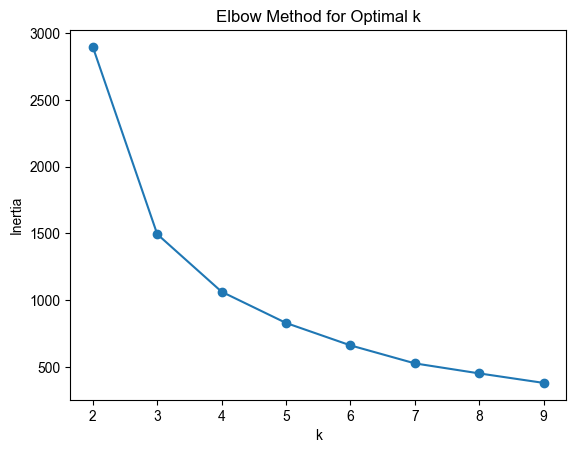

In [40]:
tmp_df11 = deepcopy(df)

# 감성 컬럼만 추출
sentiment_features = ['avg_negative', 'avg_neutral', 'avg_positive']

# 결측치 제거
df_cluster = df.dropna(subset=sentiment_features).copy()

# 감성 컬럼 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[sentiment_features])

# 적절한 클러스터 개수 선택 - Elbow Method
inertias = []
K = range(2, 10)

for k in K :
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

##### KMeans 클러스터링 적용

In [41]:
k = 3   # 선택한 클러스터 수
kmeans = KMeans(n_clusters=k, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# 클러스터별 감성 프로파일 확인
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),  # 원래 감성 값 스케일로 되돌리기
    columns=sentiment_features
)
cluster_centers['cluster'] = cluster_centers.index

cluster_centers

/Users/taeheon/miniforge3/envs/stock_price/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


avg_negative  avg_neutral  avg_positive  cluster
0      0.526627     0.236205      0.237164        0
1      0.086862     0.257965      0.655171        1
2      0.057518     0.809847      0.132635        2

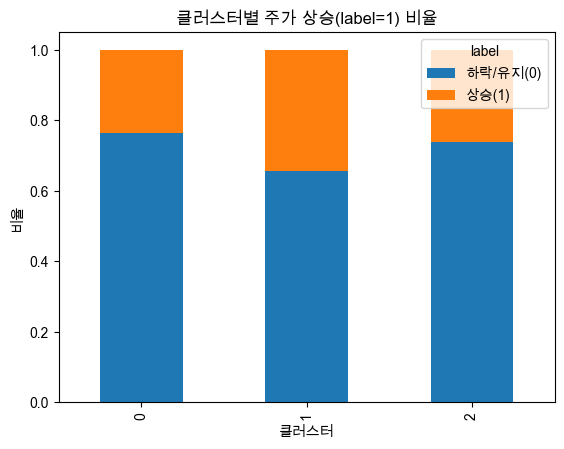

In [42]:
cluster_label_dist = df_cluster.groupby('cluster')['label'].value_counts(normalize=True).unstack()
cluster_label_dist.plot(kind='bar', stacked=True)

plt.title('클러스터별 주가 상승(label=1) 비율')
plt.ylabel('비율')
plt.xlabel('클러스터')
plt.legend(title='label', labels=['하락/유지(0)', '상승(1)'])
plt.show()


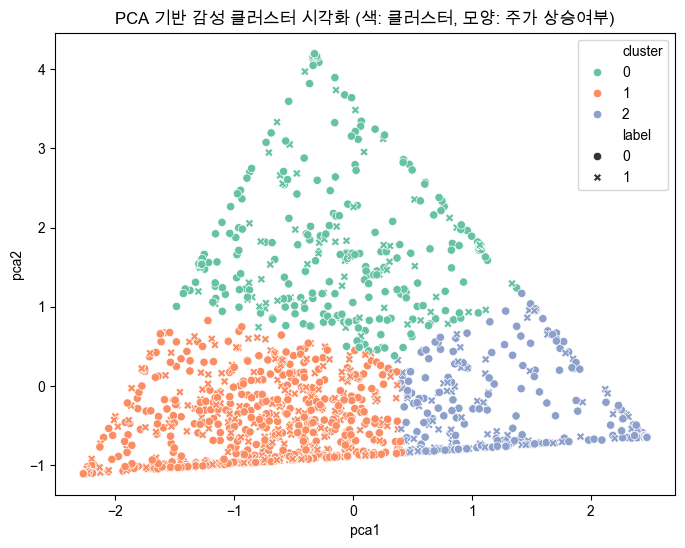

In [43]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_cluster['pca1'] = X_pca[:, 0]
df_cluster['pca2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='pca1', y='pca2', hue='cluster',
    style='label', palette='Set2',
    data=df_cluster
)
plt.title('PCA 기반 감성 클러스터 시각화 (색: 클러스터, 모양: 주가 상승여부)')
plt.show()

##### 시간에 따른 클러스터 출현 시각화
- 감성 유형이 시간 순서상 어떻게 분포했는지 분석

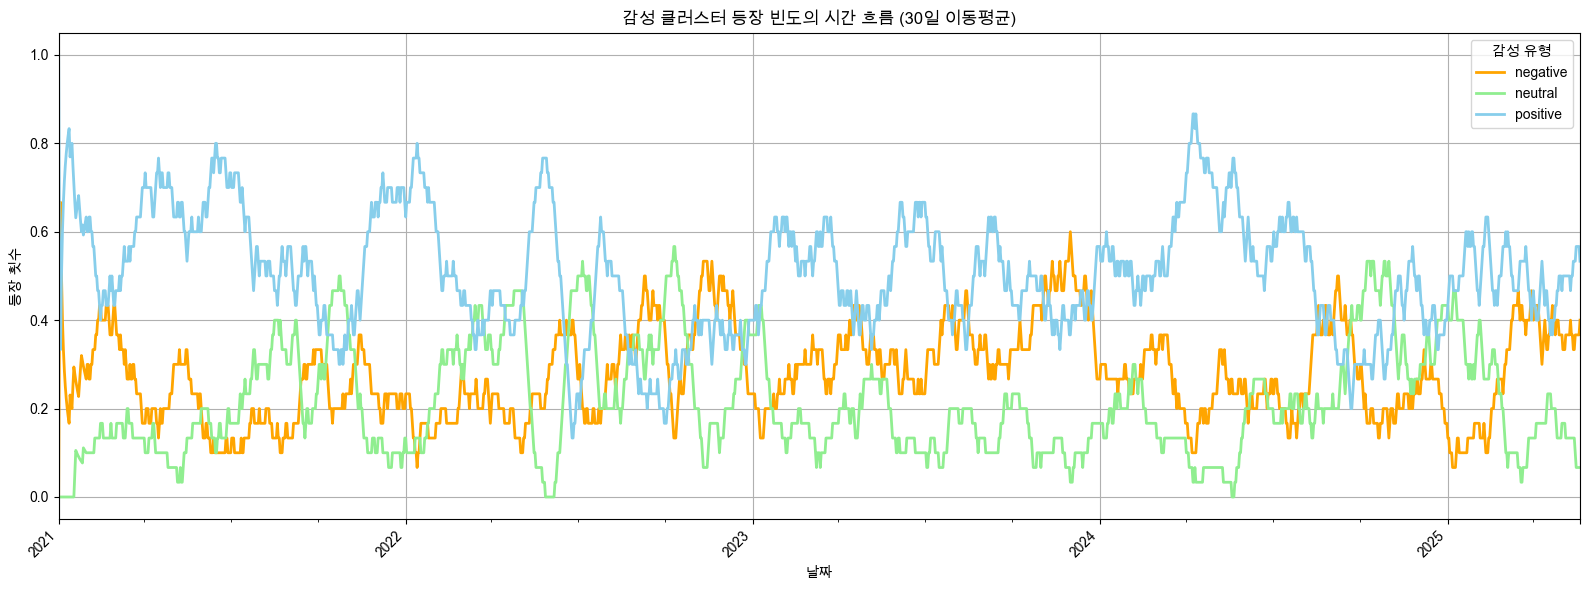

In [44]:
# 클러스터 이름 매핑
cluster_label_map = {0: 'neutral', 1: 'positive', 2: 'negative'}
df_cluster['cluster_name'] = df_cluster['cluster'].map(cluster_label_map)

# 날짜 기준으로 클러스터별 빈도 계산
daily_counts = df_cluster.groupby(['date', 'cluster_name']).size().unstack(fill_value=0)

# 이동평균 적용 (옵션)
smoothed = daily_counts.rolling(window=30, min_periods=1).mean()

# 선 그래프로 시각화
smoothed.plot(
    kind='line',
    figsize=(16, 6),
    color=['orange', 'lightgreen', 'skyblue'],
    linewidth=2
)

plt.title('감성 클러스터 등장 빈도의 시간 흐름 (30일 이동평균)')
plt.xlabel('날짜')
plt.ylabel('등장 횟수')
plt.xticks(rotation=45, ha='right')
plt.legend(title='감성 유형')
plt.grid(True)
plt.tight_layout()
plt.show()

##### 30일 이동평균 기준 감성 클러스터 등장 빈도의 시간 흐름
- x축 : 2021 ~ 2025
- y축 : 감성 클러스터 등장 비율 (0~1)
- 파랑색 : 긍정 / 초록색 : 중립 / 주황색 : 부정

**1. 긍정 감성**
- 전반적으로 가장 높은 비중을 유지
- 특정 시점(2021년 초/중반, 2022년 초/중반, 2024년 초)에는 비율이 0.7~0.8 이상 급등
- 해당 기간에 긍정적 뉴스가 유난히 많았다는 것을 시사

**2. 부정 감성**
- 전반적으로 낮은 비중
- 2022년 후반, 2023년 중반, 2025년 초에 급등 현상
- 해당 기간에 부정적 뉴스가 몰렸음을 시사

**3. 중립 감성**
- 전체 기간 동안 0.2~0.4 사이를 넓게 오가며 비교적 안정된 흐름
- 가끔 긍정과 부정의 교차 지점에서 중립 감성이 상대적으로 커짐

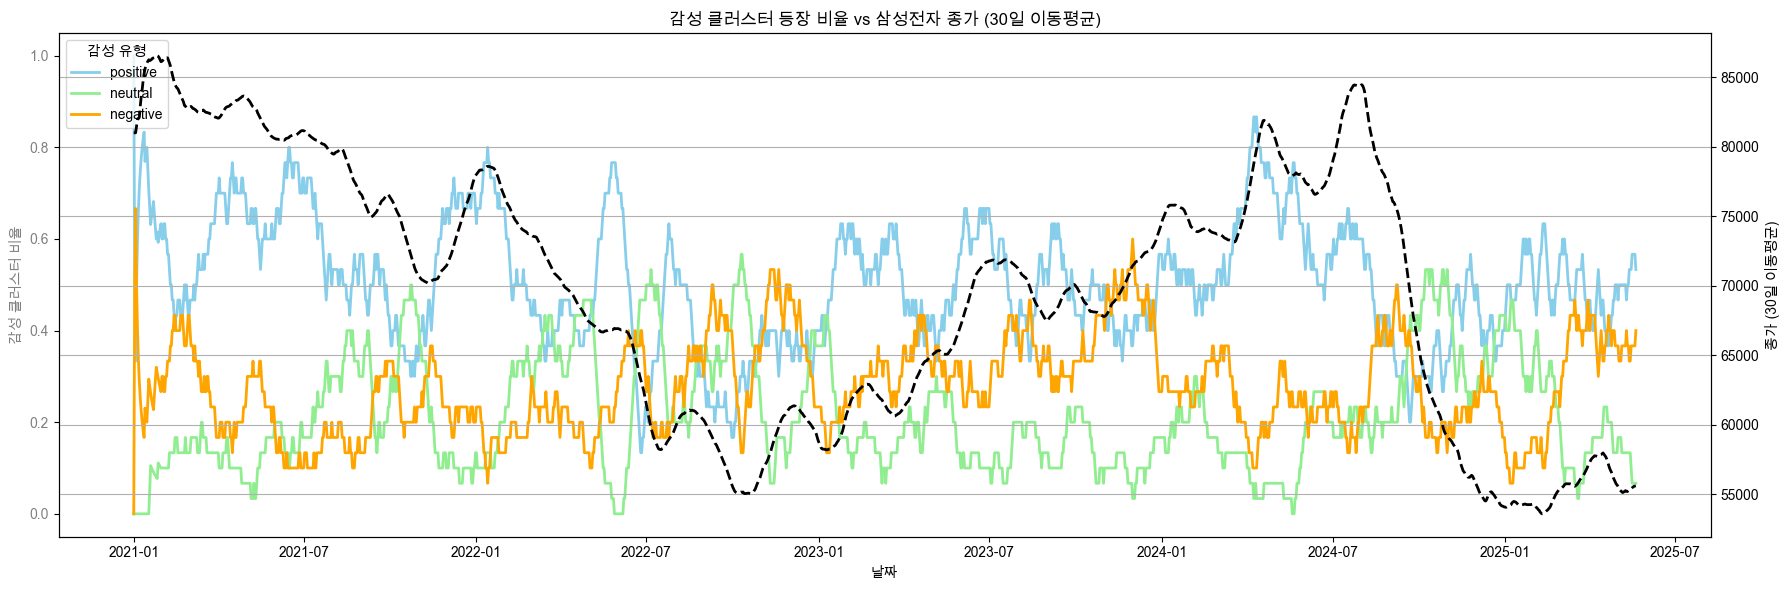

In [ ]:
# 종가 시계열 만들기
df_cluster_sorted = df_cluster.sort_values('date')
close_series = df_cluster_sorted.set_index('date')['close']

# 30일 이동평균 계산
close_rolling = close_series.rolling(window=30, min_periods=1).mean()

# 시각화 시작
fig, ax1 = plt.subplots(figsize=(18, 6))

#  감성 클러스터 등장 비율 (좌측 Y축)
ax1.plot(smoothed.index, smoothed['positive'], label='positive', color='skyblue', linewidth=2)
ax1.plot(smoothed.index, smoothed['neutral'], label='neutral', color='lightgreen', linewidth=2)
ax1.plot(smoothed.index, smoothed['negative'], label='negative', color='orange', linewidth=2)

ax1.set_xlabel('날짜')
ax1.set_ylabel('감성 클러스터 비율', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.legend(loc='upper left', title='감성 유형')
ax1.set_title('감성 클러스터 등장 비율 vs 삼성전자 종가 (30일 이동평균)')

#  삼성전자 종가 (우측 Y축)
ax2 = ax1.twinx()
ax2.plot(close_rolling.index, close_rolling, label='Close (30d MA)', color='black', linewidth=2, linestyle='--')
ax2.set_ylabel('종가 (30일 이동평균)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# 마무리
fig.tight_layout()
plt.grid(True)
plt.show()


#### 감성 클러스터별 주가 상승(label=1) 확률 분석

감성 클러스터별 주가 상승 확률:

cluster_name
positive    0.342822
negative    0.261745
neutral     0.236994
Name: 주가 상승 확률, dtype: float64


/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_42209/926634100.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


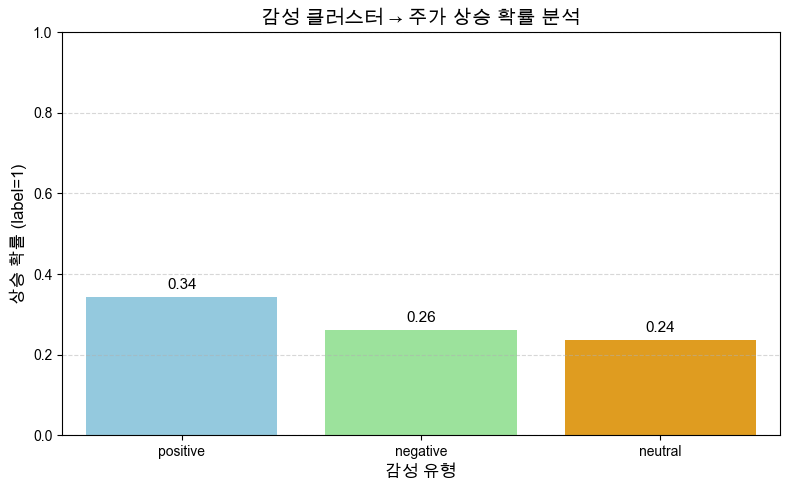

In [46]:
# 1. 클러스터명을 감성 이름으로 매핑
cluster_label_map = {0: 'neutral', 1: 'positive', 2: 'negative'}
df_cluster['cluster_name'] = df_cluster['cluster'].map(cluster_label_map)

# 2. 감성 클러스터별 label=1의 확률 계산 (즉, 상승 확률 평균)
prob_table = (
    df_cluster.groupby('cluster_name')['label']
    .mean()
    .rename('주가 상승 확률')
    .sort_values(ascending=False)
)

# 3. 출력
print("감성 클러스터별 주가 상승 확률:\n")
print(prob_table)

# 4. 시각화
plt.figure(figsize=(8, 5))
sns.barplot(
    x=prob_table.index,
    y=prob_table.values,
    palette=['skyblue', 'lightgreen', 'orange']
)

# 시각화 세부 설정
plt.title('감성 클러스터 → 주가 상승 확률 분석', fontsize=14)
plt.ylabel('상승 확률 (label=1)', fontsize=12)
plt.xlabel('감성 유형', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# 정확한 확률 숫자 표시
for i, v in enumerate(prob_table.values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()


# 7. feature engineering
- EDA 기반 파생변수 생성
    - close_diff : 전일 대비 종가 차이
    - momentum_3d : 3일간 모멘텀
    - sentiment_strenght : 긍정과 부정 간 감정 강도 차이(절댓값)
    - news_density_change : 전날 대비 뉴스 개수 변화량

In [12]:
print(f"원본 데이터프레임 features : {list(df.columns)}")

원본 데이터프레임 features : ['date', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 'news_count', 'avg_negative', 'avg_neutral', 'avg_positive', 'open', 'high', 'low', 'close', 'volume', 'label']


In [17]:
# 이동평균 20일을 위한 21년 1월 1일 이전 주가 데이터 추가 수집
# 수집 기간 지정
start_date = datetime.strptime("2020-12-01", "%Y-%m-%d")
end_date = datetime.strptime("2021-01-01", "%Y-%m-%d")

# 티커 (삼성전자)
samsung = yf.Ticker("005930.KS")

# 전체 기간 동안 주말 포함한 날짜 리스트 생성
date_list = pd.date_range(start=start_date, end=end_date, freq='D').strftime('%Y-%m-%d').tolist()

# 결과 리스트 초기화
all_data = []

for target_date in tqdm(date_list):
    next_date = (datetime.strptime(target_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
    
    try:
        hist = samsung.history(start=target_date, end=next_date, auto_adjust=False)

        if not hist.empty:
            hist = hist.reset_index()
            hist.columns = hist.columns.str.lower()
            hist['date'] = pd.to_datetime(hist['date']).dt.date.astype(str)
            hist = hist[['date', 'open', 'high', 'low', 'close', 'volume']]
            all_data.append(hist.iloc[0].to_dict())
        else:
            # 날짜는 있지만 거래가 없던 날 (공휴일 또는 이슈)
            all_data.append({
                'date': target_date,
                'open': np.nan,
                'high': np.nan,
                'low': np.nan,
                'close': np.nan,
                'volume': np.nan
            })

    except Exception as e:
        print(f"{target_date} 에러 발생: {e}")
        all_data.append({
            'date': target_date,
            'open': np.nan,
            'high': np.nan,
            'low': np.nan,
            'close': np.nan,
            'volume': np.nan
        })

# 결과 DataFrame 생성
full_df = pd.DataFrame(all_data)

full_df[['open', 'high', 'low', 'close', 'volume']] = full_df[
    ['open', 'high', 'low', 'close', 'volume']
].ffill()

print(f"총 수집 날짜 수 : {len(full_df)}")
# 결과 확인
full_df

  0%|          | 0/32 [00:00<?, ?it/s]$005930.KS: possibly delisted; no price data found  (1d 2020-12-05 -> 2020-12-06)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-06 -> 2020-12-07)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-12 -> 2020-12-13)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-13 -> 2020-12-14)
 56%|█████▋    | 18/32 [00:00<00:00, 176.73it/s]$005930.KS: possibly delisted; no price data found  (1d 2020-12-19 -> 2020-12-20)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-20 -> 2020-12-21)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-25 -> 2020-12-26)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-26 -> 2020-12-27)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-27 -> 2020-12-28)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-31 -> 2021-01-01)
$005930.KS: possibly delisted; no price data found  (1d 2021-01-01 -> 2021-01-02)
100%|███████

총 수집 날짜 수 : 32


date     open     high      low    close      volume
0   2020-12-01  67100.0  68300.0  67100.0  67800.0  22327173.0
1   2020-12-02  68400.0  69900.0  68300.0  69500.0  29703942.0
2   2020-12-03  70100.0  70500.0  69300.0  69700.0  23677989.0
3   2020-12-04  70400.0  72100.0  70100.0  71500.0  28130533.0
4   2020-12-05  70400.0  72100.0  70100.0  71500.0  28130533.0
5   2020-12-06  70400.0  72100.0  70100.0  71500.0  28130533.0
6   2020-12-07  72400.0  73500.0  71900.0  72900.0  28490496.0
7   2020-12-08  72200.0  72900.0  71600.0  71700.0  25000338.0
8   2020-12-09  72100.0  73900.0  72000.0  73900.0  24077996.0
9   2020-12-10  72700.0  73800.0  72500.0  72900.0  39882928.0
10  2020-12-11  73500.0  73800.0  73100.0  73400.0  18486672.0
11  2020-12-12  73500.0  73800.0  73100.0  73400.0  18486672.0
12  2020-12-13  73500.0  73800.0  73100.0  73400.0  18486672.0
13  2020-12-14  73600.0  74500.0  73200.0  73800.0  21510415.0
14  2020-12-15  73800.0  74100.0  73300.0  73800.0  20863671.0
15  2020-12-16  74100.0  74500.0  73400.0  73800.0  17512081.0
16  2020-12-17  73400.0  73700.0  72600.0  73300.0  24293214.0
17  2020-12-18  73300.0  73700.0  73000.0  73000.0  17613029.0
18  2020-12-19  73300.0  73700.0  73000.0  73000.0  17613029.0
19  2020-12-20  73300.0  73700.0  73000.0  73000.0  17613029.0
20  2020-12-21  73100.0  73400.0  72000.0  73000.0  20367355.0
21  2020-12-22  72500.0  73200.0  72100.0  72300.0  16304910.0
22  2020-12-23  72400.0  74000.0  72300.0  73900.0  19411326.0
23  2020-12-24  74100.0  78800.0  74000.0  77800.0  32502870.0
24  2020-12-25  74100.0  78800.0  74000.0  77800.0  32502870.0
25  2020-12-26  74100.0  78800.0  74000.0  77800.0  32502870.0
26  2020-12-27  74100.0  78800.0  74000.0  77800.0  32502870.0
27  2020-12-28  79000.0  80100.0  78200.0  78700.0  40085044.0
28  2020-12-29  78800.0  78900.0  77300.0  78300.0  30339449.0
29  2020-12-30  77400.0  81300.0  77300.0  81000.0  29417421.0
30  2020-12-31  77400.0  81300.0  77300.0  81000.0  29417421.0
31  2021-01-01  77400.0  81300.0  77300.0  81000.0  29417421.0

In [ ]:
# 기존 데이터와 concat
tmp_df12 = deepcopy(df)

# 필요한 컬럼 목록 추출 (뉴스 원문 컬럼들 포함)
full_columns = tmp_df12.columns.tolist()

# 없는 컬럼을 full_df에 추가 (값은 NaN)
for col in full_columns:
    if col not in full_df.columns:
        full_df[col] = np.nan

# 컬럼 순서 맞추기
full_df = full_df[full_columns]

# 날짜 기준 오름차순 정렬 보장 (선택사항, 안하면 concat 순서 그대로)
full_df = full_df.sort_values(by='date')

# 위쪽에 full_df 연결
merged_df = pd.concat([full_df, tmp_df12], axis=0).reset_index(drop=True)

print(len(tmp_df12), len(merged_df))
# 결과 확인
merged_df.head(2)

1601 1633


date    1    2    3    4    5    6    7    8    9  ... news_count  \
0  2020-12-01  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...        NaN   
1  2020-12-02  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...        NaN   

  avg_negative avg_neutral avg_positive     open     high      low    close  \
0          NaN         NaN          NaN  67100.0  68300.0  67100.0  67800.0   
1          NaN         NaN          NaN  68400.0  69900.0  68300.0  69500.0   

       volume label  
0  22327173.0   NaN  
1  29703942.0   NaN  

[2 rows x 50 columns]

In [26]:
def generate_custom_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # 1. close_diff: 전일 대비 종가 차이
    df['close_diff'] = df['close'].diff()

    # 2. momentum_5d: 5일간의 모멘텀 (현재 종가 - 5일 전 종가)
    df['momentum_5d'] = df['close'] - df['close'].shift(5)

    # 3. momentum_15d: 15일간의 모멘텀
    df['momentum_15d'] = df['close'] - df['close'].shift(15)

    # 4. 5일 이동평균
    df['5ma'] = df['close'].rolling(window=5).mean()

    # 5. 120일 이동평균
    df['20ma'] = df['close'].rolling(window=20).mean()

    # 6. sentiment_strength: 긍정과 부정 간 감정 강도 차이 (절대값)
    df['sentiment_strength'] = (df['avg_positive'] - df['avg_negative']).abs()

    # 7. news_density_change: 전날 대비 뉴스 개수 변화량
    df['news_density_change'] = df['news_count'].diff()

    # 결측치 제거 (NaN 발생 컬럼 기준)
    df.dropna(subset=[
        'close_diff',
        'momentum_5d',
        'momentum_15d',
        '5ma',
        '20ma',
        'news_density_change'
    ], inplace=True)

    return df


In [27]:
tmp_df13 = deepcopy(df)

tmp_df13 = generate_custom_features(tmp_df13)

print(f"파생변수 포함 데이터프레임 features : {list(tmp_df13.columns)}")
tmp_df13.to_csv("250520_weekend_sentiment_stock_feature.csv", index=False)

파생변수 포함 데이터프레임 features : ['date', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 'news_count', 'avg_negative', 'avg_neutral', 'avg_positive', 'open', 'high', 'low', 'close', 'volume', 'label', 'close_diff', 'momentum_5d', 'momentum_15d', '5ma', '20ma', 'sentiment_strength', 'news_density_change']
